**INSTITUTO TECNOLÓGICO DE ESTUDIOS SUPERIORES DE MONTERREY**

**Escuela de Ingeniería y Ciencias - Ingeniería en Ciencia de Datos y Matemáticas**

## Evidencia Final 2
### Proyecto de aprendizaje no supervisado
Modelación del aprendizaje con inteligencia artificial (Gpo 302) - TC2034.302

**Profesora:** Dra. María Valentina Narváez Terán

**Equipo 3**

Annette Pamela Ruiz Abreu - A01423595

Leslie Ramos Gutiérrez - A01562461

Rodrigo González Zermeño - A00572213

Sarah Dorado Romo - A01540946

Monterrey, Nuevo León. 11 de junio de 2023


In [692]:
# Librerías
import pandas as pd
import numpy as np
import statistics as stat
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')
import warnings
warnings.filterwarnings("ignore")
import random

from sklearn.mixture import GaussianMixture as GMM
from pywaffle import Waffle
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from imblearn.ensemble import BalancedBaggingClassifier

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster import hierarchy
from sklearn.cluster import DBSCAN



Datos: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset


In [617]:
# Cargar datos
raw_data = pd.read_csv("healthcare-dataset-stroke-data.csv")

## Exploración de datos (crudos)

In [618]:
print("Cantidad de filas:", len(raw_data))
print("Cantidad de columnas:", len(raw_data.columns))

Cantidad de filas: 5110
Cantidad de columnas: 12


In [619]:
raw_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [620]:
raw_data.keys()

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [621]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [622]:
raw_data.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

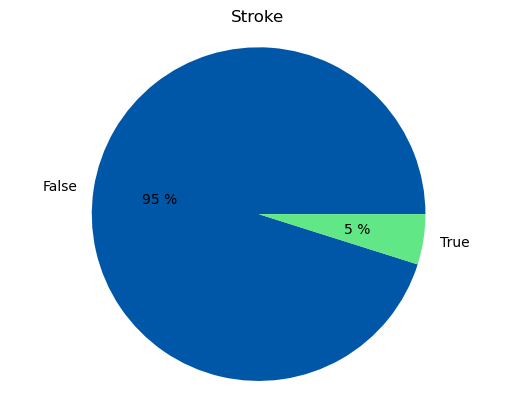

In [623]:
# Exploración de columna de interés (label)

raw_data["stroke"].value_counts()
plt.pie(raw_data["stroke"].value_counts(),labels=["False","True"], autopct="%0.0f %%", colors=["#0057A7", "#61E786"])
plt.axis("equal")
plt.title("Stroke")
plt.show()

In [624]:
raw_data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [625]:
for i in raw_data.drop(labels=["id", "age", "avg_glucose_level", "bmi"], axis=1):
    display(pd.DataFrame(raw_data[i].value_counts()))


,gender
Female,2994
Male,2115
Other,1


,hypertension
0,4612
1,498


,heart_disease
0,4834
1,276


,ever_married
Yes,3353
No,1757


,work_type
Private,2925
Self-employed,819
children,687
Govt_job,657
Never_worked,22


,Residence_type
Urban,2596
Rural,2514


,smoking_status
never smoked,1892
Unknown,1544
formerly smoked,885
smokes,789


,stroke
0,4861
1,249


## Limpieza de datos

In [626]:
datos = raw_data
no_bmi = datos[datos["bmi"].isna()]

# Como "bmi" es la única columna que tiene datos vacíos, llenaremos esos datos vacíos con la mediana
datos['bmi'].fillna(round (datos['bmi'].median(), 2), inplace=True)
datos = datos.drop("id", axis=1).reset_index(drop=True)

# Eliminamos el dato que no tiene género (dice "Otro")
datos = datos.drop(datos[datos["gender"]=="Other"].index)



In [627]:
# Creación de categorías para la visualización

datos['bmi_category'] = pd.cut(datos['bmi'], bins = [0, 19, 25,30,10000], labels = ['Underweight', 'Ideal', 'Overweight', 'Obesity'])
datos['age_group'] = pd.cut(datos['age'], bins = [0,13,18, 45,60,200], labels = ['Children', 'Teens', 'Adults','Mid Adults','Elderly'])
datos['glucose_category'] = pd.cut(datos['avg_glucose_level'], bins = [0,90,160,230,500], labels = ['Low', 'Normal', 'High', 'Very High'])

datos.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_category,age_group,glucose_category
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,Obesity,Elderly,High
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1,Overweight,Elderly,High
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,Obesity,Elderly,Normal
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,Obesity,Mid Adults,High
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,Ideal,Elderly,High


In [628]:
# Transformación de datos para optimizar memoria

datos["gender"] = datos["gender"].astype("category")
datos["hypertension"] = datos["hypertension"].astype("bool")
datos["heart_disease"] = datos["heart_disease"].astype("bool")
datos["ever_married"] = datos["ever_married"].replace({"Yes":1, "No":0}).astype("bool")
datos["work_type"] = datos["work_type"].astype("category")
datos["Residence_type"] = datos["Residence_type"].astype("category")
datos["smoking_status"] = datos["smoking_status"].astype("category")
datos["stroke"] = datos["stroke"].astype("bool")


## Exploración de datos limpios

In [629]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   gender             5109 non-null   category
 1   age                5109 non-null   float64 
 2   hypertension       5109 non-null   bool    
 3   heart_disease      5109 non-null   bool    
 4   ever_married       5109 non-null   bool    
 5   work_type          5109 non-null   category
 6   Residence_type     5109 non-null   category
 7   avg_glucose_level  5109 non-null   float64 
 8   bmi                5109 non-null   float64 
 9   smoking_status     5109 non-null   category
 10  stroke             5109 non-null   bool    
 11  bmi_category       5109 non-null   category
 12  age_group          5109 non-null   category
 13  glucose_category   5109 non-null   category
dtypes: bool(4), category(7), float64(3)
memory usage: 215.8 KB


In [630]:
print("Cantidad de filas:", len(datos))
print("Cantidad de columnas:", len(datos.columns))

Cantidad de filas: 5109
Cantidad de columnas: 14


In [631]:
# Exploración datos cuantitativos
datos.describe()


,age,avg_glucose_level,bmi
count,5109.000000,5109.000000,5109.000000
mean,43.229986,106.140399,28.863300
std,22.613575,45.285004,7.699785
min,0.080000,55.120000,10.300000
25%,25.000000,77.240000,23.800000
50%,45.000000,91.880000,28.100000
75%,61.000000,114.090000,32.800000
max,82.000000,271.740000,97.600000


In [632]:
pd.DataFrame(datos.agg(stat.mode)).rename(columns={0:"mode"})

,mode
gender,Female
age,78.0
hypertension,False
heart_disease,False
ever_married,True
work_type,Private
Residence_type,Urban
avg_glucose_level,93.88
bmi,28.1
smoking_status,never smoked


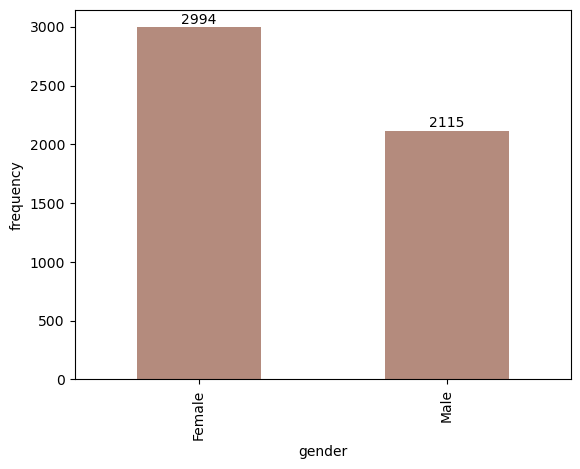

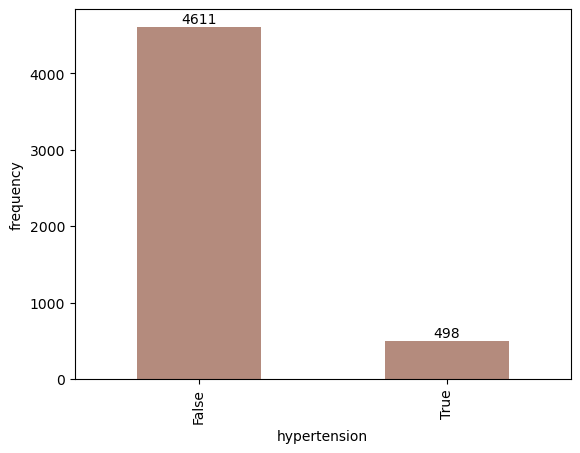

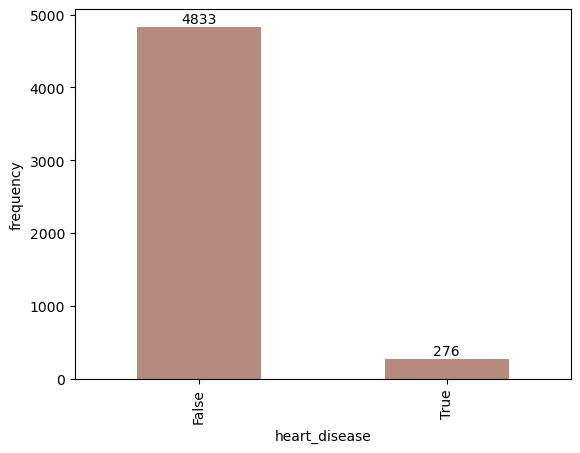

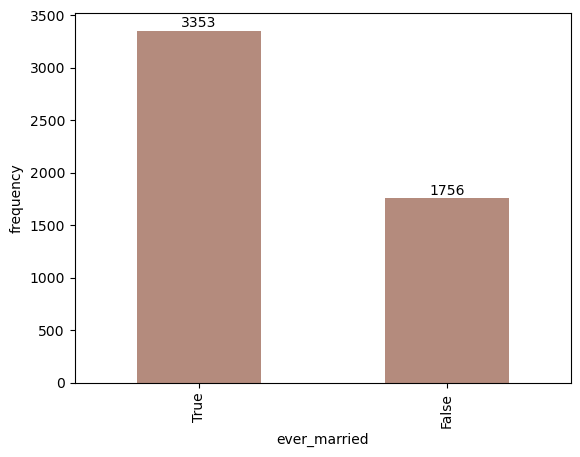

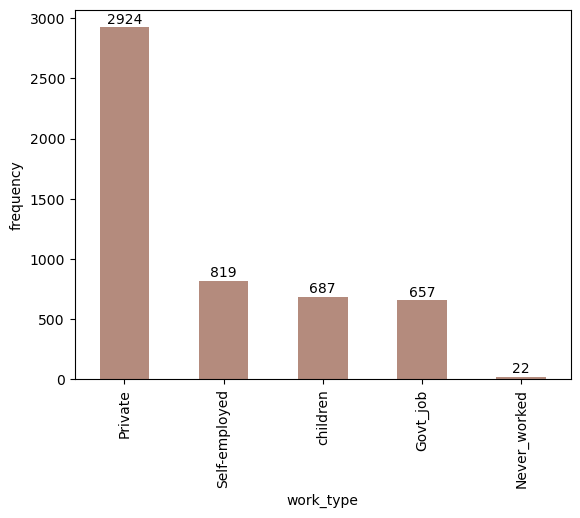

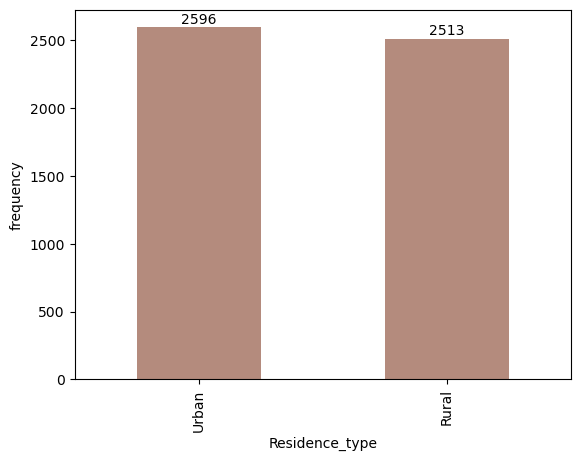

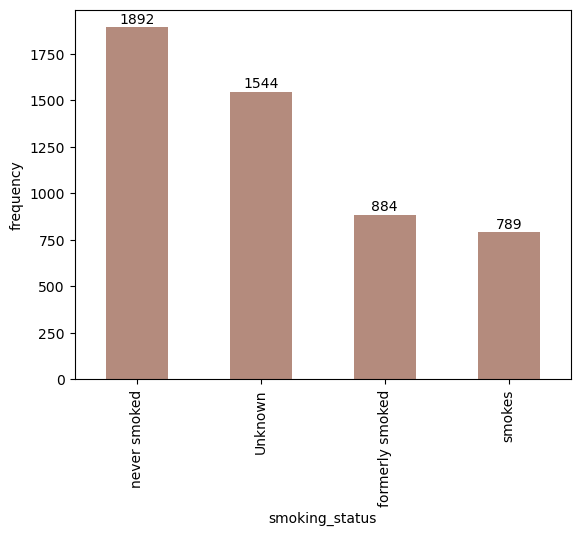

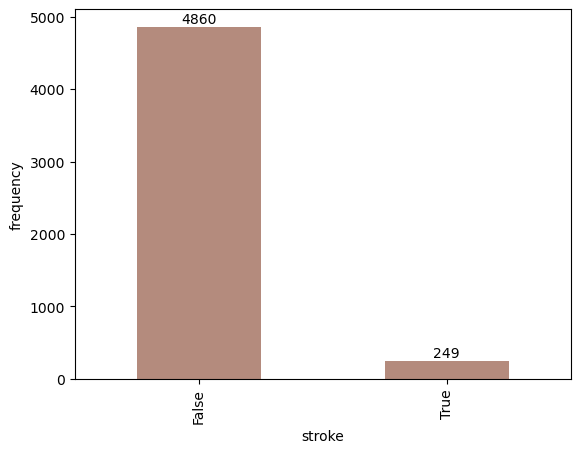

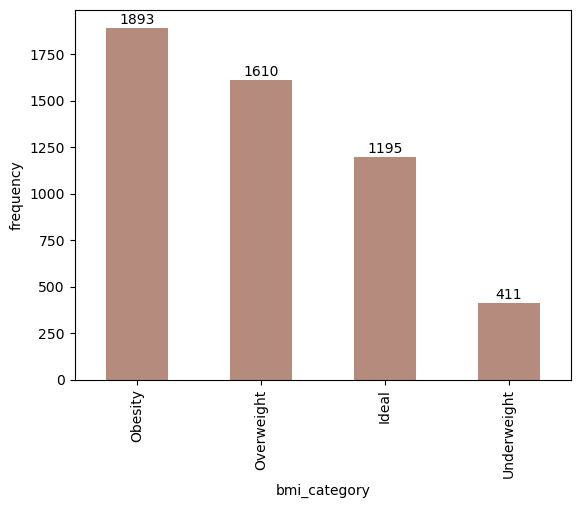

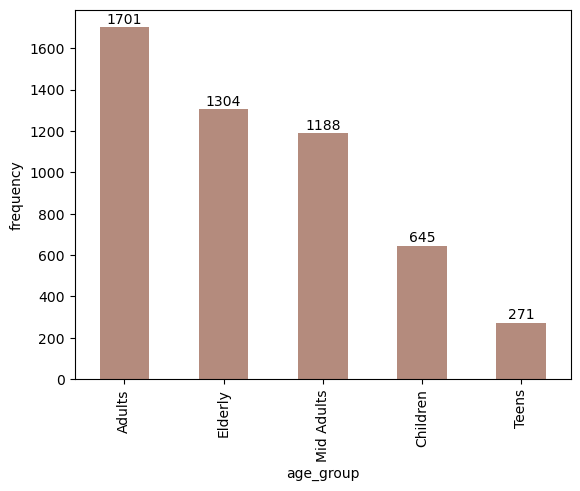

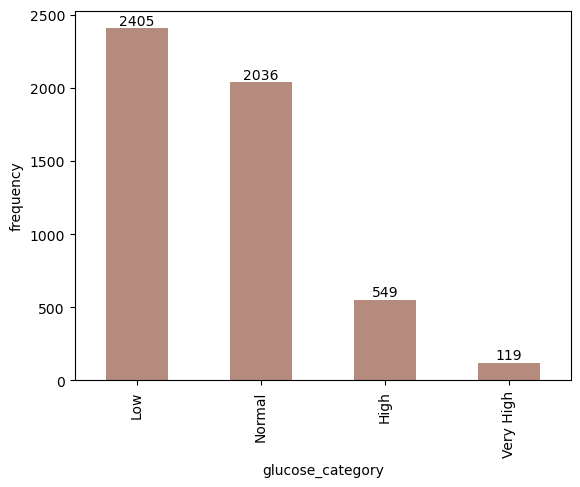

In [633]:
# Exploración variables cualitativas

for i in datos.drop(labels=["age", "avg_glucose_level", "bmi"], axis=1):
    fig = datos[i].value_counts().plot(kind='bar', xlabel=i , ylabel='frequency', color="#B48B7D")
    rects = fig.patches

    # Make some labels.
    labels = [j for j in datos[i].value_counts()]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        fig.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
        )

    plt.show()
    print("\n\n")


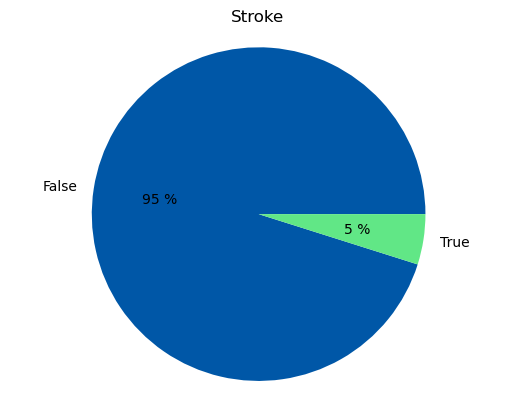

In [634]:
# Exploración de columna de interés (label)
plt.pie(datos["stroke"].value_counts(),labels=["False","True"], autopct="%0.0f %%", colors=["#0057A7", "#61E786"])
plt.axis("equal")
plt.title("Stroke")
plt.show()

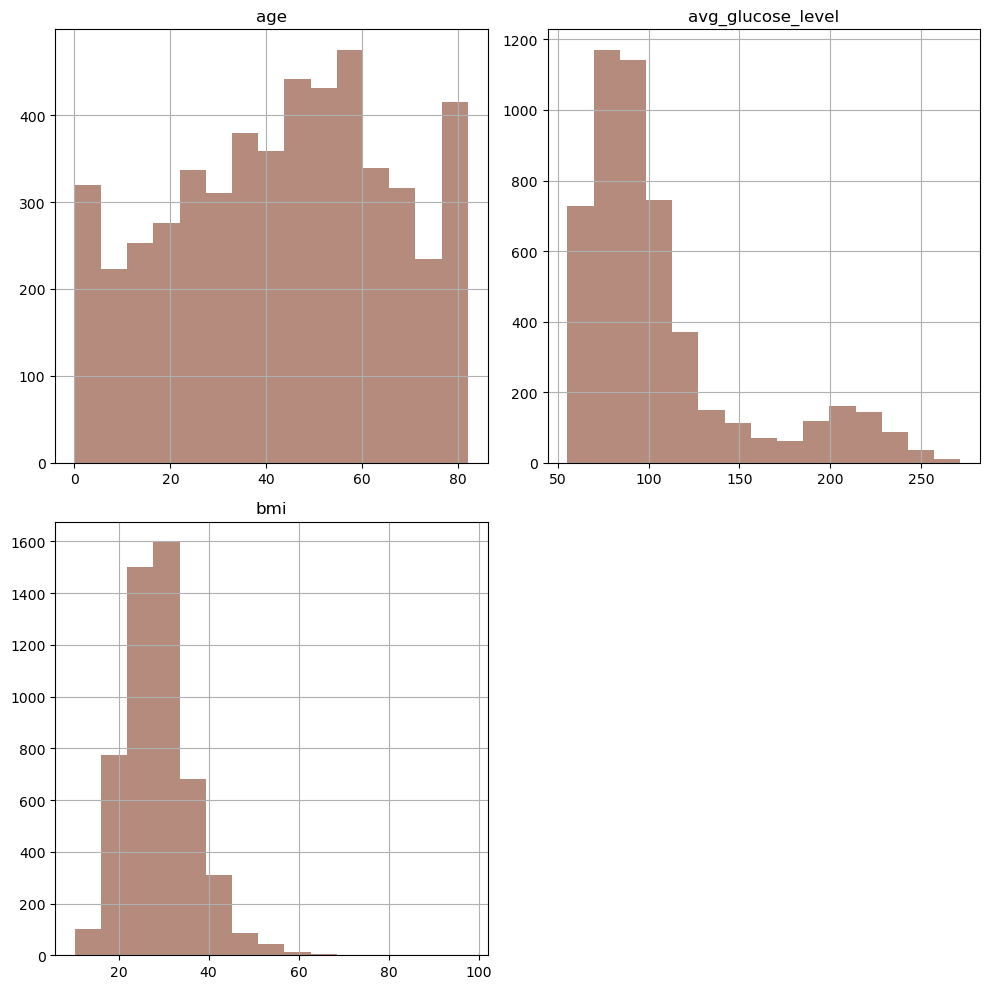

In [635]:
datos.hist(bins=15, figsize=(10,10), color="#B48B7D")
plt.tight_layout()


stroke
age_group  stroke        
Children   False      644
           True         1
Teens      False      270
           True         1
Adults     False     1690
           True        11
Mid Adults False     1129
           True        59
Elderly    False     1127
           True       177

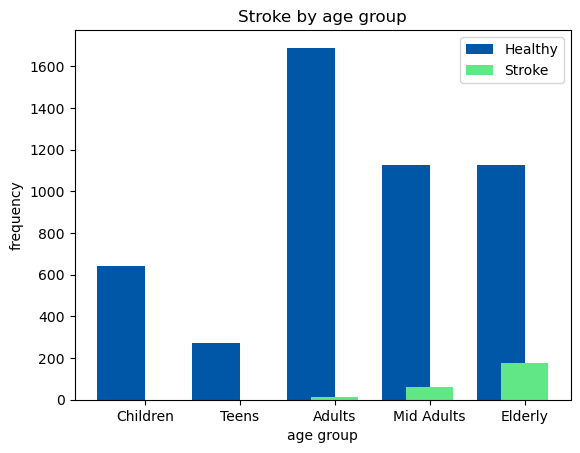

In [636]:
# Análisis de edad

grouped_age = pd.DataFrame(datos.groupby(["age_group"])["stroke"].value_counts())
display(grouped_age)

stroke_age = datos[datos['stroke'] == 1].age_group.value_counts().sort_index(ascending=True)
healthy_age = datos[datos['stroke'] == 0].age_group.value_counts().sort_index(ascending=True)

labels=[" "]+list(stroke_age.index.categories)


x = np.arange(len(stroke_age.values))
width = 0.5


fig, ax = plt.subplots()
ax.bar(x-width/2, healthy_age.values, width, label="Healthy", color="#0057A7")
ax.bar(x, stroke_age.values, width, label="Stroke", color="#61E786")


ax.set_title("Stroke by age group")
ax.set_ylabel("frequency")
ax.set_xlabel("age group")
ax.set_xticklabels(labels)
plt.legend()
plt.show()


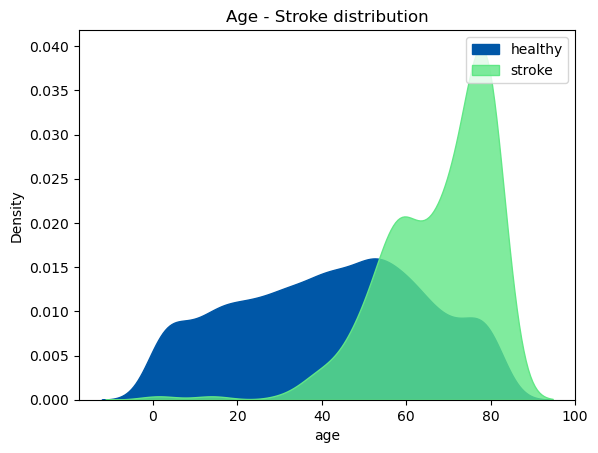

In [637]:
sns.kdeplot(data = datos[datos['stroke'] == 0], x = 'age', shade = True,  alpha = 1, color = '#0057A7', label="healthy")
sns.kdeplot(data = datos[datos['stroke'] == 1], x = 'age', shade = True,  alpha = 0.8, color = '#61E786', label="stroke")
plt.title("Age - Stroke distribution")
plt.legend()
plt.show()


stroke
glucose_category stroke        
Low              False     2316
                 True        89
Normal           False     1965
                 True        71
High             False      478
                 True        71
Very High        False      101
                 True        18

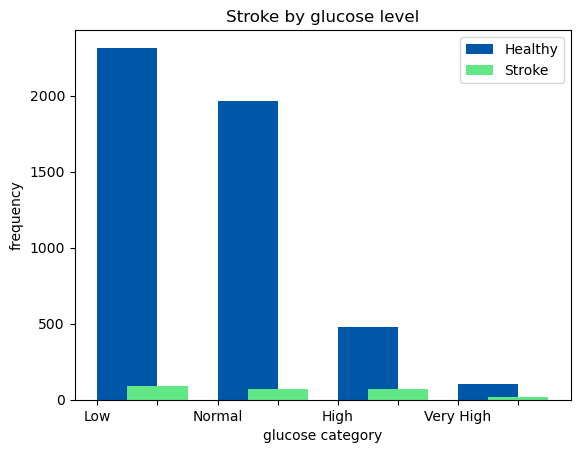

In [638]:
# Análisis de glucosa
glucosa = pd.DataFrame(datos.groupby(["glucose_category"])["stroke"].value_counts())
display(glucosa)

stroke_cat = datos[datos['stroke'] == 1].glucose_category.value_counts().sort_index(ascending=True)
healthy_cat = datos[datos['stroke'] == 0].glucose_category.value_counts().sort_index(ascending=True)

labels = list(stroke_cat.index.categories)
labels = [" ", labels[0], " ", labels[1], " ", labels[2], " ", labels[3]]

x = np.arange(len(stroke_cat.values))
width = 0.5


fig, ax = plt.subplots()
ax.bar(x-width/2, healthy_cat.values, width, label="Healthy", color="#0057A7")
ax.bar(x, stroke_cat.values, width, label="Stroke", color="#61E786")


ax.set_title("Stroke by glucose level")
ax.set_ylabel("frequency")
ax.set_xlabel("glucose category")
ax.set_xticklabels(labels)
plt.legend()
plt.show()


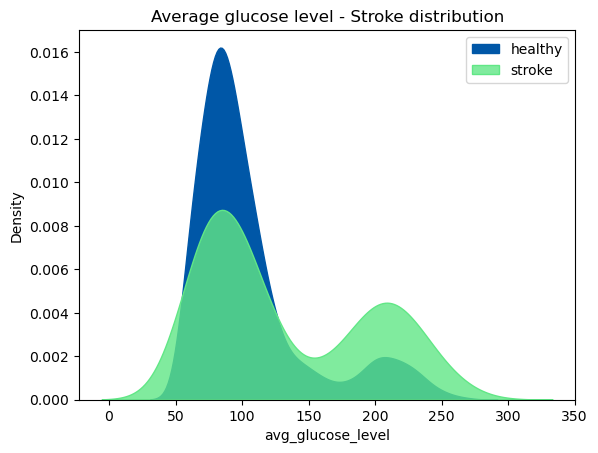

In [639]:
sns.kdeplot(data = datos[datos['stroke'] == 0], x = 'avg_glucose_level', shade = True,  alpha = 1, color = '#0057A7', label="healthy")
sns.kdeplot(data = datos[datos['stroke'] == 1], x = 'avg_glucose_level', shade = True,  alpha = 0.8, color = '#61E786', label="stroke")
plt.title("Average glucose level - Stroke distribution")
plt.legend()
plt.show()

stroke
bmi_category stroke        
Underweight  False      410
             True         1
Ideal        False     1158
             True        37
Overweight   False     1495
             True       115
Obesity      False     1797
             True        96

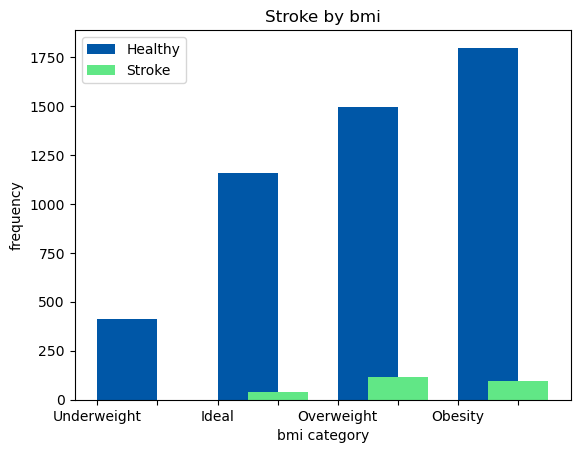

In [640]:
# Análisis de bmi
bmi = pd.DataFrame(datos.groupby(["bmi_category"])["stroke"].value_counts())
display(bmi)

stroke_bmi = datos[datos['stroke'] == 1].bmi_category.value_counts().sort_index(ascending=True)
healthy_bmi = datos[datos['stroke'] == 0].bmi_category.value_counts().sort_index(ascending=True)

labels = list(stroke_bmi.index.categories)
labels = [" ", labels[0], " ", labels[1], " ", labels[2], " ", labels[3]]

x = np.arange(len(stroke_bmi.values))
width = 0.5


fig, ax = plt.subplots()
ax.bar(x-width/2, healthy_bmi.values, width, label="Healthy", color="#0057A7")
ax.bar(x, stroke_bmi.values, width, label="Stroke", color="#61E786")


ax.set_title("Stroke by bmi")
ax.set_ylabel("frequency")
ax.set_xlabel("bmi category")
ax.set_xticklabels(labels)
plt.legend()
plt.show()


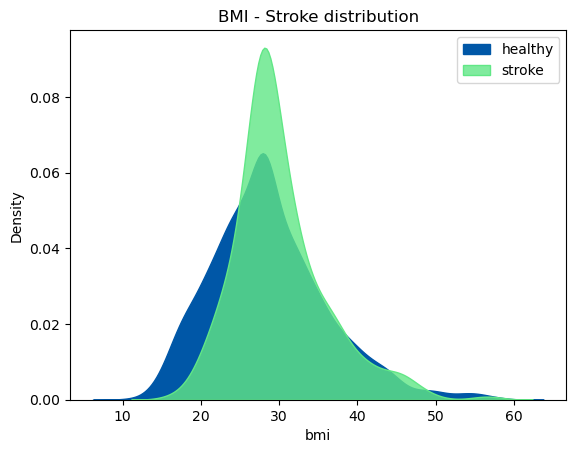

In [641]:
d = datos[datos['stroke'] == 0]
a = datos[datos['stroke'] == 1]
sns.kdeplot(data = d[d["bmi"]<=60], x = 'bmi', shade = True,  alpha = 1, color = '#0057A7', label="healthy")
sns.kdeplot(data = a[a["bmi"]<=60], x = 'bmi', shade = True,  alpha = 0.8, color = '#61E786', label="stroke")
plt.title("BMI - Stroke distribution")
plt.legend()
plt.show()

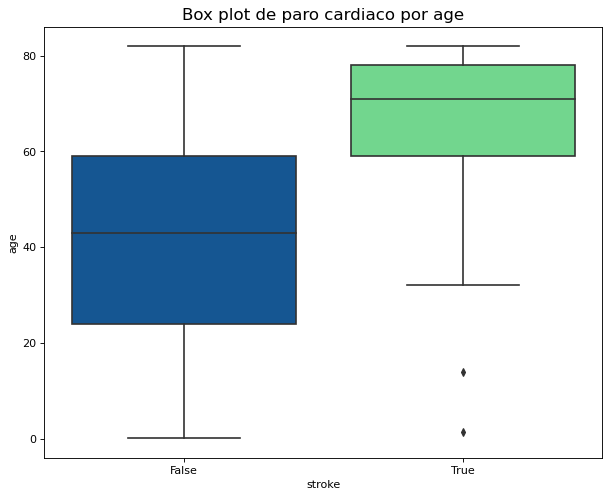

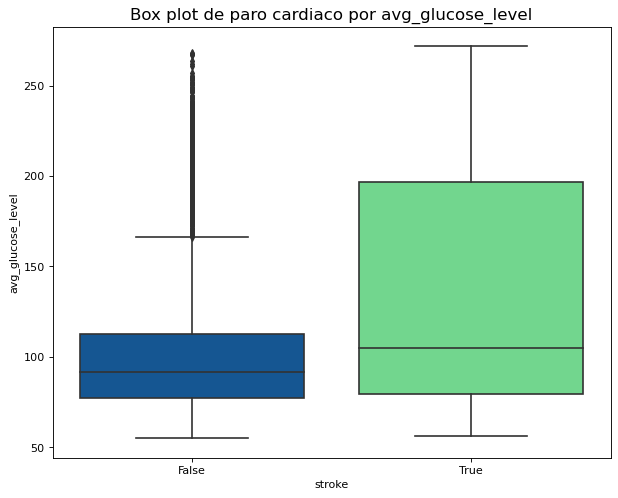

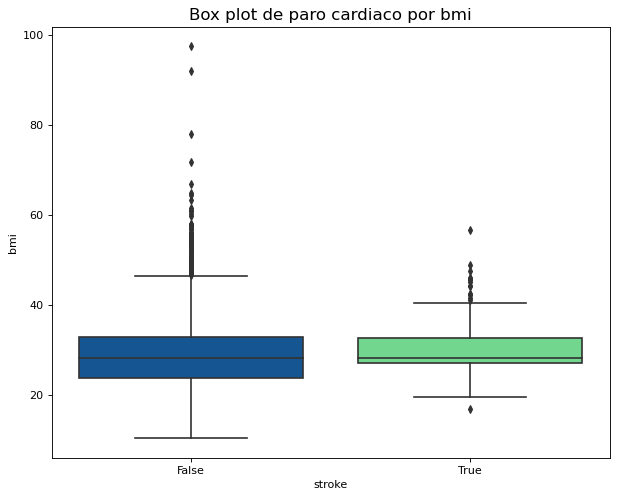

In [642]:
# Boxplots
cuantitativas = ["age", "avg_glucose_level", "bmi"]

for i in cuantitativas:
    plt.figure(figsize=(9,7), dpi= 80)
    sns.boxplot(x='stroke', y=i, data=datos, notch=False, palette=["#0057A7", "#61E786"])
    title = 'Box plot de paro cardiaco por '+i
    plt.title(title, fontsize=15)
    plt.show()



In [643]:
healthy_col = "#0057A7"
stroke_col = "#61E786"

stroke
gender stroke        
Female False     2853
       True       141
Male   False     2007
       True       108

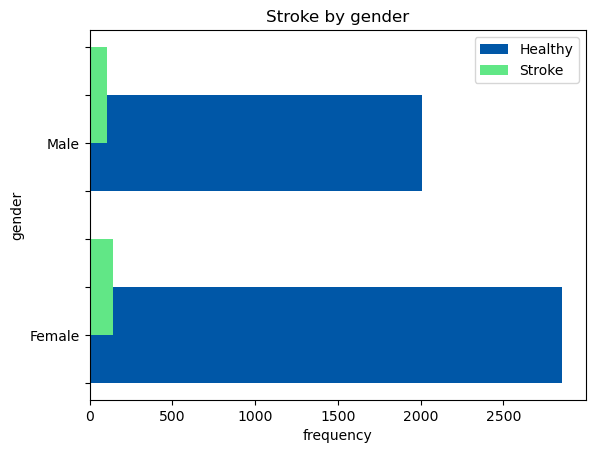

In [644]:
gender = pd.DataFrame(datos.groupby(["gender"])["stroke"].value_counts())
display(gender)

stroke_gender = datos[datos['stroke'] == 1].gender.value_counts().sort_index(ascending=True)
healthy_gender = datos[datos['stroke'] == 0].gender.value_counts().sort_index(ascending=True)

labels = list(stroke_gender.index.categories)
labels = [" ", " ", labels[0], " ", " ", " ", labels[1]]

x = np.arange(len(stroke_gender.values))
width = 0.5


fig, ax = plt.subplots()
ax.barh(x-width/2, healthy_gender.values, width, label="Healthy", color=healthy_col)
ax.barh(x, stroke_gender.values, width, label="Stroke", color=stroke_col)


ax.set_title("Stroke by gender")
ax.set_xlabel("frequency")
ax.set_ylabel("gender")
ax.set_yticklabels(labels)
plt.legend()
plt.show()


stroke
hypertension stroke        
False        False     4428
             True       183
True         False      432
             True        66

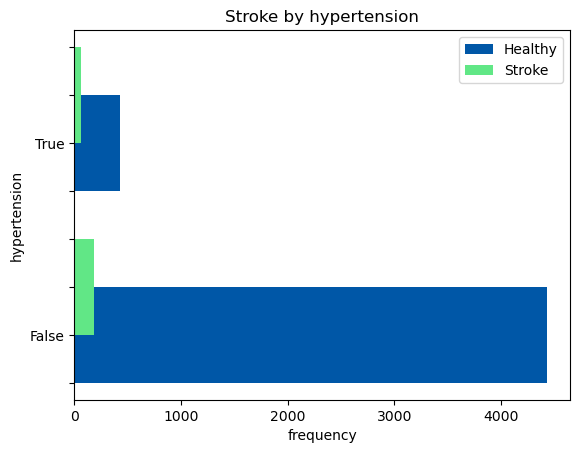

In [645]:
hypertension = pd.DataFrame(datos.groupby(["hypertension"])["stroke"].value_counts())
display(hypertension)

stroke_hypertension = datos[datos['stroke'] == 1].hypertension.value_counts().sort_index(ascending=True)
healthy_hypertension = datos[datos['stroke'] == 0].hypertension.value_counts().sort_index(ascending=True)


x = np.arange(len(stroke_hypertension.values))
width = 0.5


fig, ax = plt.subplots()
ax.barh(x-width/2, healthy_hypertension.values, width, label="Healthy", color=healthy_col)
ax.barh(x, stroke_hypertension.values, width, label="Stroke", color=stroke_col)


ax.set_title("Stroke by hypertension")
ax.set_xlabel("frequency")
ax.set_ylabel("hypertension")
ax.set_yticklabels(["", "", "False", "", "", "", "True"])
plt.legend()
plt.show()

stroke
heart_disease stroke        
False         False     4631
              True       202
True          False      229
              True        47

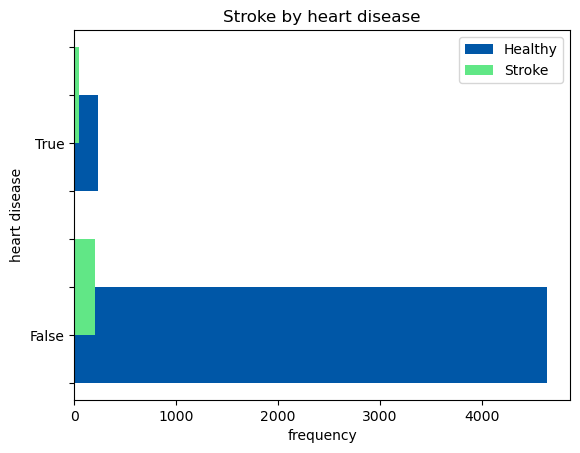

In [646]:
heart = pd.DataFrame(datos.groupby(["heart_disease"])["stroke"].value_counts())
display(heart)

stroke_heart = datos[datos['stroke'] == 1].heart_disease.value_counts().sort_index(ascending=True)
healthy_heart = datos[datos['stroke'] == 0].heart_disease.value_counts().sort_index(ascending=True)


x = np.arange(len(stroke_heart.values))
width = 0.5


fig, ax = plt.subplots()
ax.barh(x-width/2, healthy_heart.values, width, label="Healthy", color=healthy_col)
ax.barh(x, stroke_heart.values, width, label="Stroke", color=stroke_col)


ax.set_title("Stroke by heart disease")
ax.set_xlabel("frequency")
ax.set_ylabel("heart disease")
ax.set_yticklabels(["", "", "False", "", "", "", "True"])
plt.legend()
plt.show()

stroke
ever_married stroke        
False        False     1727
             True        29
True         False     3133
             True       220

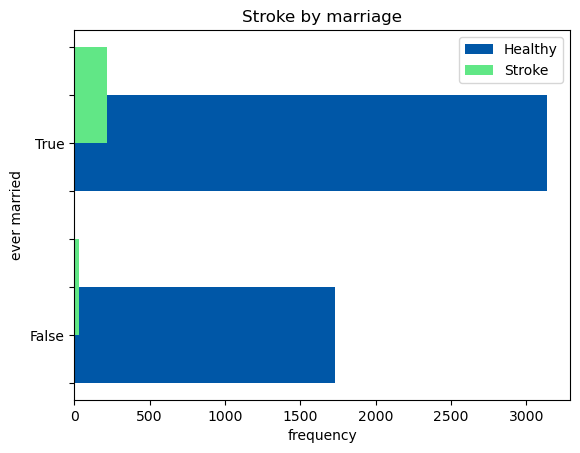

In [647]:
marriage = pd.DataFrame(datos.groupby(["ever_married"])["stroke"].value_counts())
display(marriage)

stroke_marriage = datos[datos['stroke'] == 1].ever_married.value_counts().sort_index(ascending=True)
healthy_marriage = datos[datos['stroke'] == 0].ever_married.value_counts().sort_index(ascending=True)


x = np.arange(len(stroke_marriage.values))
width = 0.5


fig, ax = plt.subplots()
ax.barh(x-width/2, healthy_marriage.values, width, label="Healthy", color=healthy_col)
ax.barh(x, stroke_marriage.values, width, label="Stroke", color=stroke_col)


ax.set_title("Stroke by marriage")
ax.set_xlabel("frequency")
ax.set_ylabel("ever married")
ax.set_yticklabels(["", "", "False", "", "", "", "True"])
plt.legend()
plt.show()

stroke
work_type     stroke        
Govt_job      False      624
              True        33
Never_worked  False       22
Private       False     2775
              True       149
Self-employed False      754
              True        65

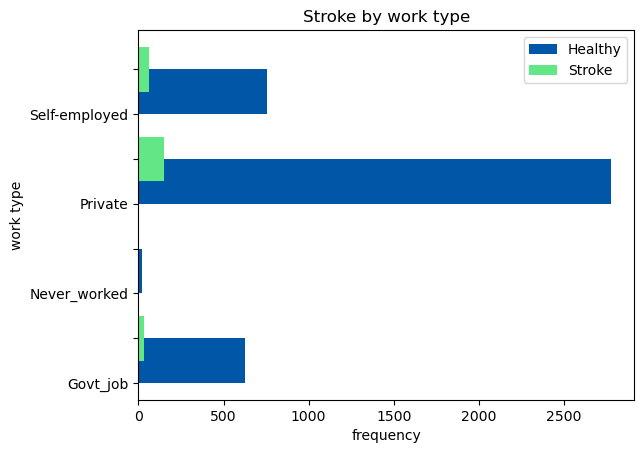

In [648]:
work = pd.DataFrame(datos.groupby(["work_type"])["stroke"].value_counts()).drop("children")
display(work)

stroke_work = datos[datos['stroke'] == 1].work_type.value_counts().sort_index(ascending=True).drop("children")
healthy_work = datos[datos['stroke'] == 0].work_type.value_counts().sort_index(ascending=True).drop("children")

labels = list(stroke_work.index.categories)
labels = [" ", labels[0], " ", labels[1], " ", labels[2], " ", labels[3]]

x = np.arange(len(stroke_work.values))
width = 0.5


fig, ax = plt.subplots()
ax.barh(x-width/2, healthy_work.values, width, label="Healthy", color=healthy_col)
ax.barh(x, stroke_work.values, width, label="Stroke", color=stroke_col)


ax.set_title("Stroke by work type")
ax.set_xlabel("frequency")
ax.set_ylabel("work type")
ax.set_yticklabels(labels)
plt.legend()
plt.show()

stroke
Residence_type stroke        
Rural          False     2399
               True       114
Urban          False     2461
               True       135

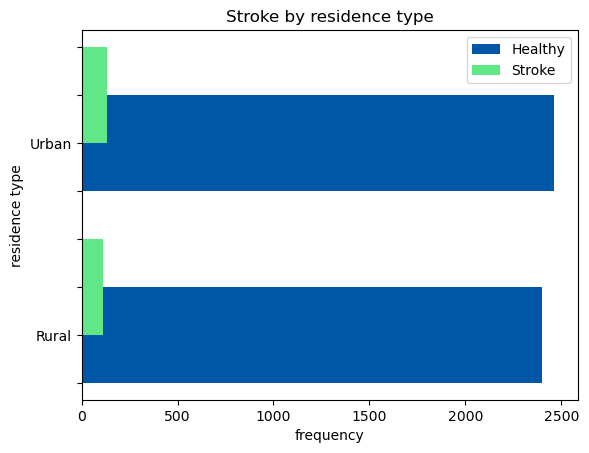

In [649]:
residence = pd.DataFrame(datos.groupby(["Residence_type"])["stroke"].value_counts())
display(residence)

stroke_residence = datos[datos['stroke'] == 1].Residence_type.value_counts().sort_index(ascending=True)
healthy_residence = datos[datos['stroke'] == 0].Residence_type.value_counts().sort_index(ascending=True)

labels = list(stroke_residence.index.categories)
labels = [" ", " ", labels[0], " ", " ", " ", labels[1]]

x = np.arange(len(stroke_residence.values))
width = 0.5


fig, ax = plt.subplots()
ax.barh(x-width/2, healthy_residence.values, width, label="Healthy", color=healthy_col)
ax.barh(x, stroke_residence.values, width, label="Stroke", color=stroke_col)


ax.set_title("Stroke by residence type")
ax.set_xlabel("frequency")
ax.set_ylabel("residence type")
ax.set_yticklabels(labels)
plt.legend()
plt.show()

stroke
smoking_status  stroke        
Unknown         False     1497
                True        47
formerly smoked False      814
                True        70
never smoked    False     1802
                True        90
smokes          False      747
                True        42

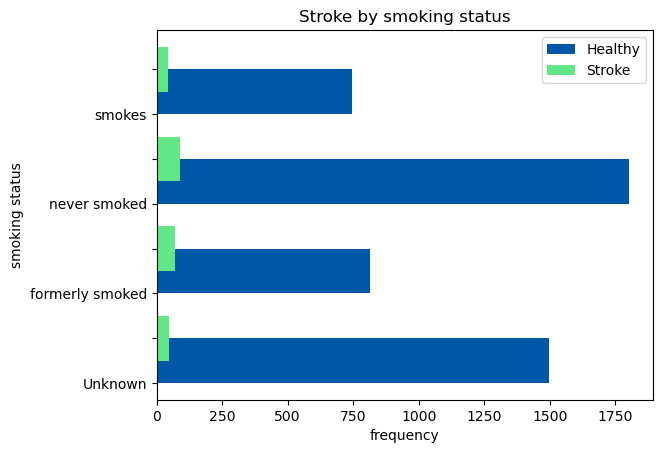

In [650]:
smoking = pd.DataFrame(datos.groupby(["smoking_status"])["stroke"].value_counts())
display(smoking)

stroke_smoking = datos[datos['stroke'] == 1].smoking_status.value_counts().sort_index(ascending=True)
healthy_smoking = datos[datos['stroke'] == 0].smoking_status.value_counts().sort_index(ascending=True)

labels = list(stroke_smoking.index.categories)
labels = [" ", labels[0], " ", labels[1], " ", labels[2], " ", labels[3]]

x = np.arange(len(stroke_smoking.values))
width = 0.5


fig, ax = plt.subplots()
ax.barh(x-width/2, healthy_smoking.values, width, label="Healthy", color=healthy_col)
ax.barh(x, stroke_smoking.values, width, label="Stroke", color=stroke_col)


ax.set_title("Stroke by smoking status")
ax.set_xlabel("frequency")
ax.set_ylabel("smoking status")
ax.set_yticklabels(labels)
plt.legend()
plt.show()

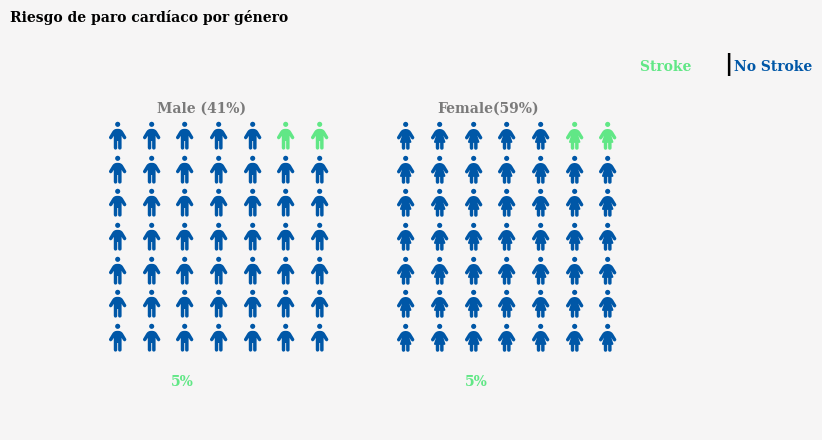

In [651]:
df = datos

stroke_gen = df[df['stroke'] == 1]['gender'].value_counts()
healthy_gen = df[df['stroke'] == 0]['gender'].value_counts()

female = df['gender'].value_counts().values[0]
male =  df['gender'].value_counts().values[1]

stroke_female = int(round (stroke_gen.values[0] / female * 100, 0))
stroke_male = int(round( stroke_gen.values[1] / male *100, 0))
healthy_female = int(round(healthy_gen.values[0] / female * 100, 0))
healthy_male = int(round(healthy_gen.values[1] / male *100, 0))

female_per = int(round(female/(female+male) * 100, 0))
male_per = int(round(male/(female+male)* 100, 0))



fig = plt.figure(FigureClass = Waffle, 
                 constrained_layout = True,
                 figsize = (7,7),
                 facecolor = '#f6f5f5',dpi = 100,
                 
                 plots = {121:
                          {     
                           'rows':7,
                           'columns': 7,
                           'values' : [healthy_male,stroke_male],
                            'colors' : [healthy_col, stroke_col],
                              'vertical' : True,
                              'interval_ratio_y': 0.1,
                              'interval_ratio_x': 0.1,
                              'icons' : 'male',
                              'icon_legend': False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.1
                          },
                          
                          122 :
                          { 
                            'rows': 7,
                            'columns':7,
                            'values':[healthy_female,stroke_female],         
                              'colors' : [healthy_col, stroke_col],
                              'vertical': True,
                              'interval_ratio_y': 0.1,
                              'interval_ratio_x': 0.1,
                              'icons' : 'female',
                              'icon_legend' :False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.1
                                                      
                           }
                         },
                   
)


fig.text(0., 0.8, 'Riesgo de paro cardíaco por género', {'font':'Serif', 'color':'black', 'weight':'bold'})
fig.text(0.24, 0.22, 'ooo', {'font':'Serif','weight':'bold' ,'color':'#f6f5f5'})
fig.text(0.65, 0.22, 'ooo', {'font':'Serif','weight':'bold', 'color':'#f6f5f5'})
fig.text(0.23, 0.28, '{}%'.format(100-healthy_male), {'font':'Serif','weight':'bold' ,'color':stroke_col},alpha = 1,)
fig.text(0.65, 0.28, '{}%'.format(100-healthy_female), {'font':'Serif','weight':'bold', 'color':stroke_col}, alpha = 1)
fig.text(0.21, 0.67, 'Male ({}%)'.format(male_per), {'font':'Serif','weight':'bold' ,'color':'black'},alpha = 0.5,)
fig.text(0.61, 0.67, 'Female({}%)'.format(female_per), {'font':'Serif','weight':'bold', 'color':'black'}, alpha = 0.5)


fig.text(0.9,0.73, 'Stroke ', {'font': 'Serif','weight':'bold','weight':'bold','style':'normal', 'color':stroke_col})
fig.text(1.02,0.73, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
fig.text(1.035,0.73, 'No Stroke', {'font': 'Serif','weight':'bold','style':'normal', 'weight':'bold','color':healthy_col},alpha = 1)


fig.show()

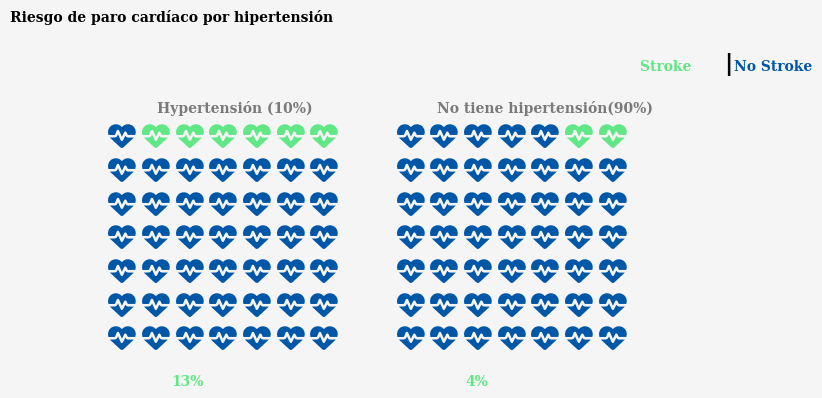

In [652]:
stroke_hypertension = df[df['stroke'] == 1]['hypertension'].value_counts()
healthy_hypertension = df[df['stroke'] == 0]['hypertension'].value_counts()

no = df['hypertension'].value_counts().values[0]
yes =  df['hypertension'].value_counts().values[1]

stroke_no = int(round (stroke_hypertension.values[0] / no * 100, 0))
stroke_yes = int(round( stroke_hypertension.values[1] / yes *100, 0))
healthy_no = int(round(healthy_hypertension.values[0] / no * 100, 0))
healthy_yes = int(round(healthy_hypertension.values[1] / yes *100, 0))

no_per = int(round(no/(no+yes) * 100, 0))
yes_per = int(round(yes/(no+yes)* 100, 0))



fig = plt.figure(FigureClass = Waffle, 
                 constrained_layout = True,
                 figsize = (7,7),
                 facecolor = '#f6f5f5',dpi = 100,
                 
                 plots = {121:
                          {     
                           'rows':7,
                           'columns': 7,
                           'values' : [healthy_yes,stroke_yes],
                            'colors' : [healthy_col, stroke_col],
                              'vertical' : True,
                              'interval_ratio_y': 0.1,
                              'interval_ratio_x': 0.1,
                              'icons' : 'heartbeat',
                              'icon_legend': False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.1
                          },
                          
                          122 :
                          { 
                            'rows': 7,
                            'columns':7,
                            'values':[healthy_no,stroke_no],         
                              'colors' : [healthy_col, stroke_col],
                              'vertical': True,
                              'interval_ratio_y': 0.1,
                              'interval_ratio_x': 0.1,
                              'icons' : 'heartbeat',
                              'icon_legend' :False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.1
                                                      
                           }
                         },
                   
)


fig.text(0., 0.8, 'Riesgo de paro cardíaco por hipertensión', {'font':'Serif', 'color':'black', 'weight':'bold'})
fig.text(0.23, 0.28, '{}%'.format(100-healthy_yes), {'font':'Serif','weight':'bold' ,'color':stroke_col},alpha = 1,)
fig.text(0.65, 0.28, '{}%'.format(100-healthy_no), {'font':'Serif','weight':'bold', 'color':stroke_col}, alpha = 1)
fig.text(0.21, 0.67, 'Hypertensión ({}%)'.format(yes_per), {'font':'Serif','weight':'bold' ,'color':'black'},alpha = 0.5,)
fig.text(0.61, 0.67, 'No tiene hipertensión({}%)'.format(no_per), {'font':'Serif','weight':'bold', 'color':'black'}, alpha = 0.5)


fig.text(0.9,0.73, 'Stroke ', {'font': 'Serif','weight':'bold','weight':'bold','style':'normal', 'color':stroke_col})
fig.text(1.02,0.73, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
fig.text(1.035,0.73, 'No Stroke', {'font': 'Serif','weight':'bold','style':'normal', 'weight':'bold','color':healthy_col},alpha = 1)


fig.show()

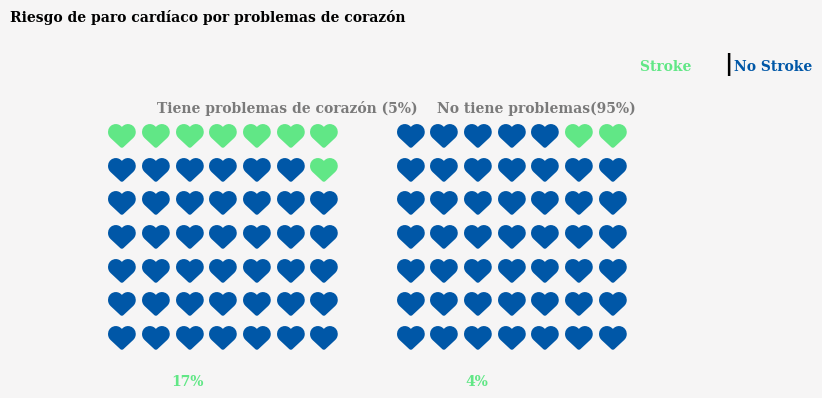

In [653]:
stroke_hypertension = df[df['stroke'] == 1]['heart_disease'].value_counts()
healthy_hypertension = df[df['stroke'] == 0]['heart_disease'].value_counts()

no = df['heart_disease'].value_counts().values[0]
yes =  df['heart_disease'].value_counts().values[1]

stroke_no = int(round (stroke_hypertension.values[0] / no * 100, 0))
stroke_yes = int(round( stroke_hypertension.values[1] / yes *100, 0))
healthy_no = int(round(healthy_hypertension.values[0] / no * 100, 0))
healthy_yes = int(round(healthy_hypertension.values[1] / yes *100, 0))

no_per = int(round(no/(no+yes) * 100, 0))
yes_per = int(round(yes/(no+yes)* 100, 0))



fig = plt.figure(FigureClass = Waffle, 
                 constrained_layout = True,
                 figsize = (7,7),
                 facecolor = '#f6f5f5',dpi = 100,
                 
                 plots = {121:
                          {     
                           'rows':7,
                           'columns': 7,
                           'values' : [healthy_yes,stroke_yes],
                            'colors' : [healthy_col, stroke_col],
                              'vertical' : True,
                              'interval_ratio_y': 0.1,
                              'interval_ratio_x': 0.1,
                              'icons' : 'heart',
                              'icon_legend': False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.1
                          },
                          
                          122 :
                          { 
                            'rows': 7,
                            'columns':7,
                            'values':[healthy_no,stroke_no],         
                              'colors' : [healthy_col, stroke_col],
                              'vertical': True,
                              'interval_ratio_y': 0.1,
                              'interval_ratio_x': 0.1,
                              'icons' : 'heart',
                              'icon_legend' :False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.1
                                                      
                           }
                         },
                   
)


fig.text(0., 0.8, 'Riesgo de paro cardíaco por problemas de corazón', {'font':'Serif', 'color':'black', 'weight':'bold'})
fig.text(0.23, 0.28, '{}%'.format(100-healthy_yes), {'font':'Serif','weight':'bold' ,'color':stroke_col},alpha = 1,)
fig.text(0.65, 0.28, '{}%'.format(100-healthy_no), {'font':'Serif','weight':'bold', 'color':stroke_col}, alpha = 1)
fig.text(0.21, 0.67, 'Tiene problemas de corazón ({}%)'.format(yes_per), {'font':'Serif','weight':'bold' ,'color':'black'},alpha = 0.5,)
fig.text(0.61, 0.67, 'No tiene problemas({}%)'.format(no_per), {'font':'Serif','weight':'bold', 'color':'black'}, alpha = 0.5)


fig.text(0.9,0.73, 'Stroke ', {'font': 'Serif','weight':'bold','weight':'bold','style':'normal', 'color':stroke_col})
fig.text(1.02,0.73, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
fig.text(1.035,0.73, 'No Stroke', {'font': 'Serif','weight':'bold','style':'normal', 'weight':'bold','color':healthy_col},alpha = 1)


fig.show()

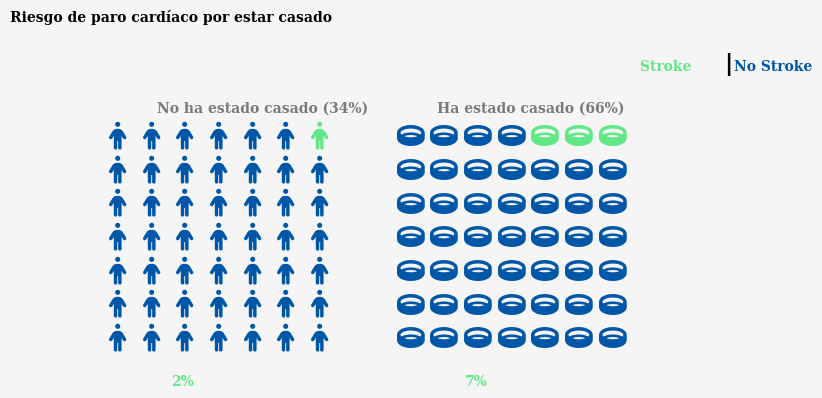

In [654]:
stroke_hypertension = df[df['stroke'] == 1]['ever_married'].value_counts()
healthy_hypertension = df[df['stroke'] == 0]['ever_married'].value_counts()

no = df['ever_married'].value_counts().values[0]
yes =  df['ever_married'].value_counts().values[1]

stroke_no = int(round (stroke_hypertension.values[0] / no * 100, 0))
stroke_yes = int(round( stroke_hypertension.values[1] / yes *100, 0))
healthy_no = int(round(healthy_hypertension.values[0] / no * 100, 0))
healthy_yes = int(round(healthy_hypertension.values[1] / yes *100, 0))

no_per = int(round(no/(no+yes) * 100, 0))
yes_per = int(round(yes/(no+yes)* 100, 0))



fig = plt.figure(FigureClass = Waffle, 
                 constrained_layout = True,
                 figsize = (7,7),
                 facecolor = '#f6f5f5',dpi = 100,
                 
                 plots = {121:
                          {     
                           'rows':7,
                           'columns': 7,
                           'values' : [healthy_yes,stroke_yes],
                            'colors' : [healthy_col, stroke_col],
                              'vertical' : True,
                              'interval_ratio_y': 0.1,
                              'interval_ratio_x': 0.1,
                              'icons' : 'person',
                              'icon_legend': False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.1
                          },
                          
                          122 :
                          { 
                            'rows': 7,
                            'columns':7,
                            'values':[healthy_no,stroke_no],         
                              'colors' : [healthy_col, stroke_col],
                              'vertical': True,
                              'interval_ratio_y': 0.1,
                              'interval_ratio_x': 0.1,
                              'icons' : 'ring',
                              'icon_legend' :False,
                              'icon_size':20,
                              'plot_anchor':'C',
                              'alpha':0.1
                                                      
                           }
                         },
                   
)


fig.text(0., 0.8, 'Riesgo de paro cardíaco por estar casado', {'font':'Serif', 'color':'black', 'weight':'bold'})
fig.text(0.23, 0.28, '{}%'.format(100-healthy_yes), {'font':'Serif','weight':'bold' ,'color':stroke_col},alpha = 1,)
fig.text(0.65, 0.28, '{}%'.format(100-healthy_no), {'font':'Serif','weight':'bold', 'color':stroke_col}, alpha = 1)
fig.text(0.21, 0.67, 'No ha estado casado ({}%)'.format(yes_per), {'font':'Serif','weight':'bold' ,'color':'black'},alpha = 0.5,)
fig.text(0.61, 0.67, 'Ha estado casado ({}%)'.format(no_per), {'font':'Serif','weight':'bold', 'color':'black'}, alpha = 0.5)


fig.text(0.9,0.73, 'Stroke ', {'font': 'Serif','weight':'bold','weight':'bold','style':'normal', 'color':stroke_col})
fig.text(1.02,0.73, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
fig.text(1.035,0.73, 'No Stroke', {'font': 'Serif','weight':'bold','style':'normal', 'weight':'bold','color':healthy_col},alpha = 1)


fig.show()

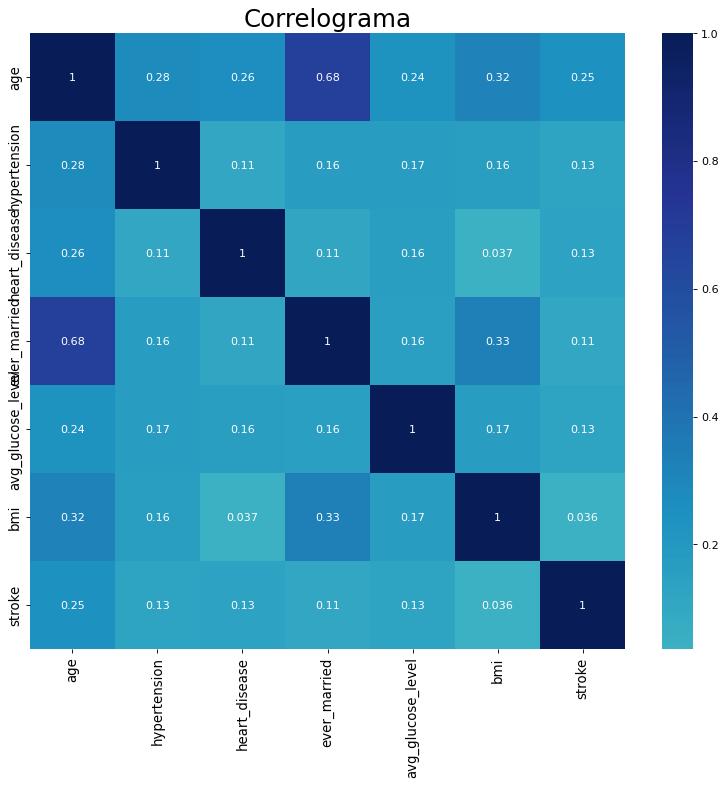

In [655]:
# Gráfica de correlación
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(datos.corr(), xticklabels=datos.corr().columns, yticklabels=datos.corr().columns, center=0, annot=True, cmap="YlGnBu")
plt.title('Correlograma', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


## Modelos de aprendizaje no supervisado

In [656]:
X = datos.drop(columns=["stroke", "bmi_category", "age_group", "glucose_category"])
y = datos["stroke"]


In [657]:
label_encoder = LabelEncoder()
labels = {}

for i in X:
    if isinstance(X[i][0],str):
        X[i] = label_encoder.fit_transform(datos[i])
        labels[i]=label_encoder.classes_

xcopia = X

X.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,1,67.0,False,True,True,2,1,228.69,36.6,1
1,0,61.0,False,False,True,3,0,202.21,28.1,2
2,1,80.0,False,True,True,2,0,105.92,32.5,2
3,0,49.0,False,False,True,2,1,171.23,34.4,3
4,0,79.0,True,False,True,3,0,174.12,24.0,2


### Clustering jerárquico

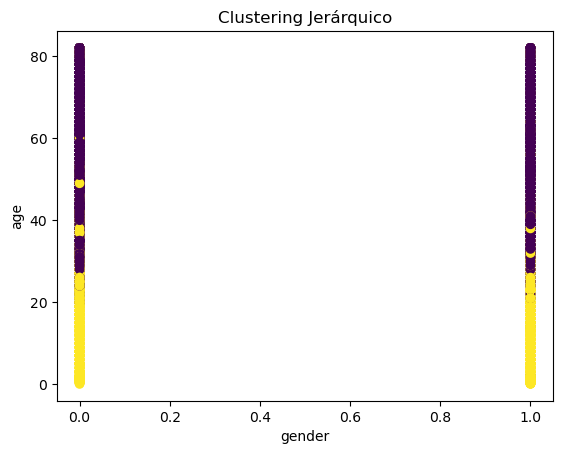

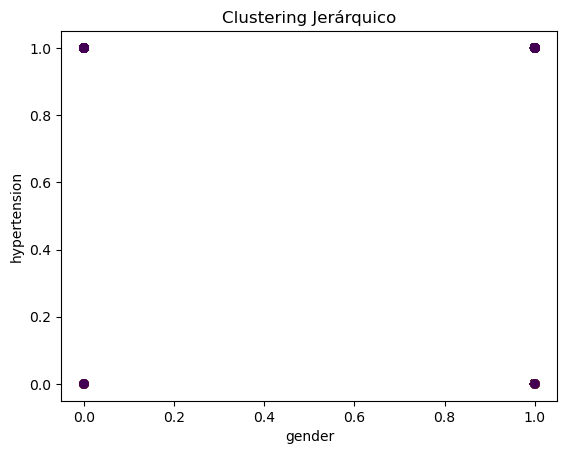

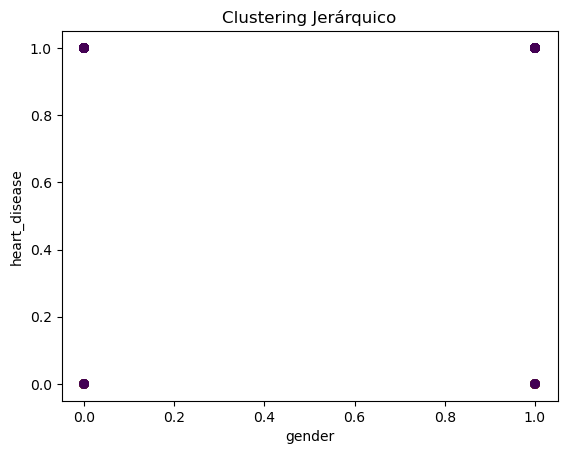

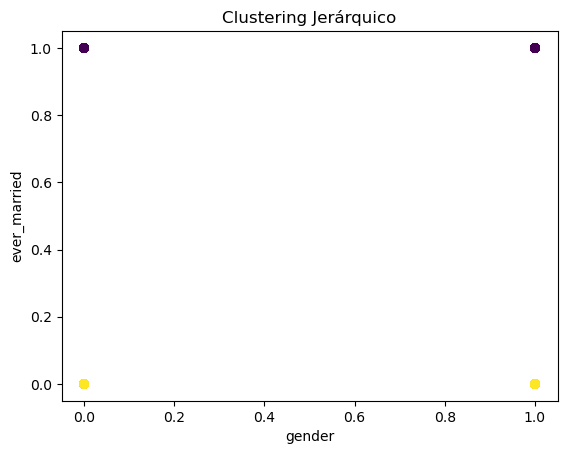

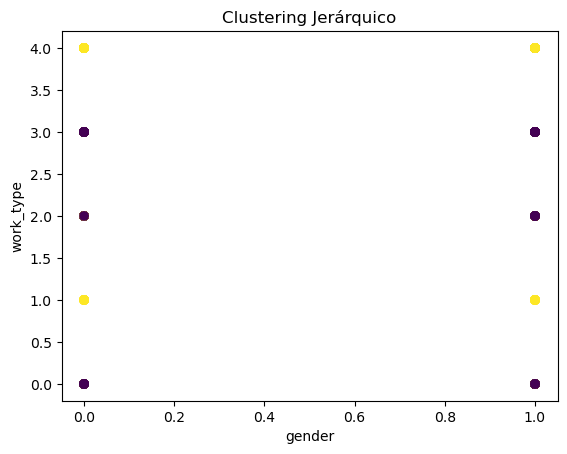

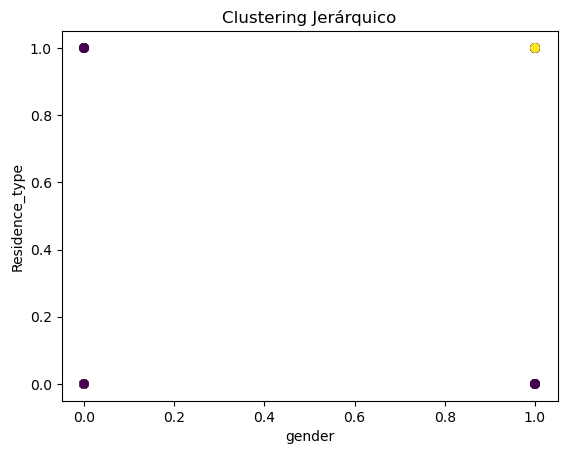

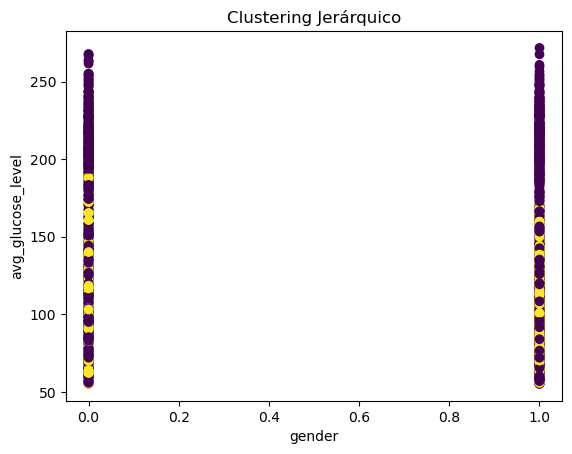

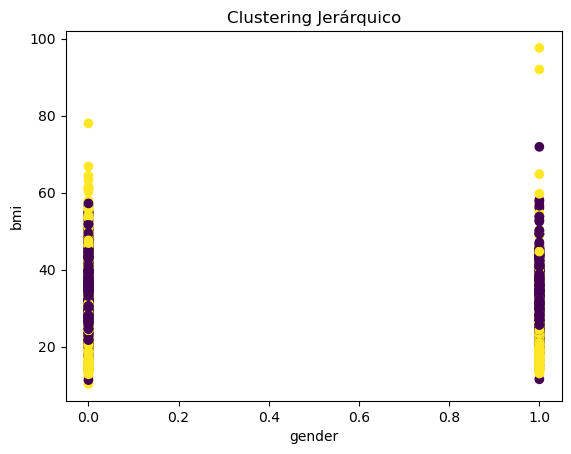

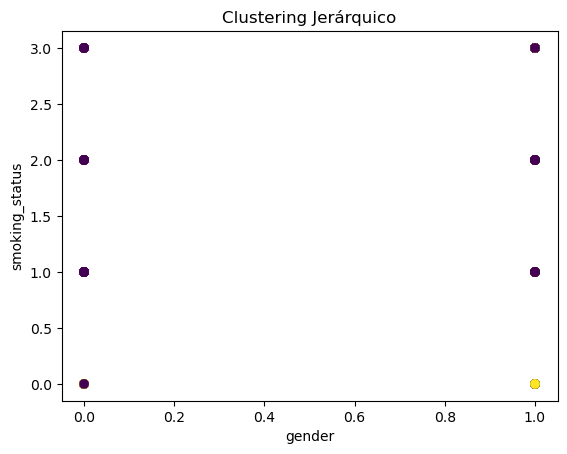

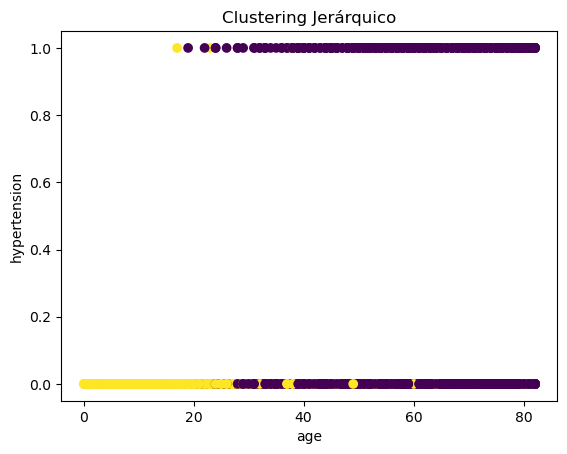

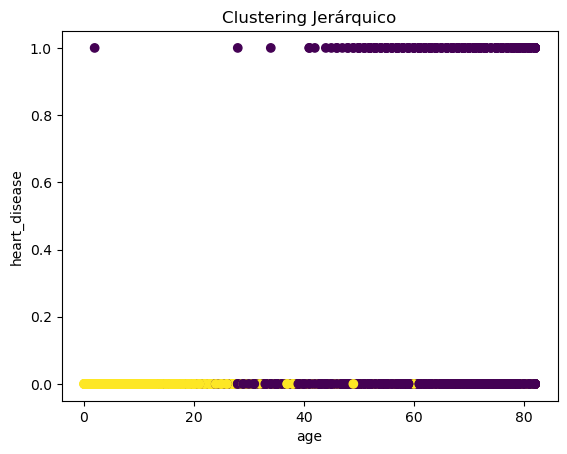

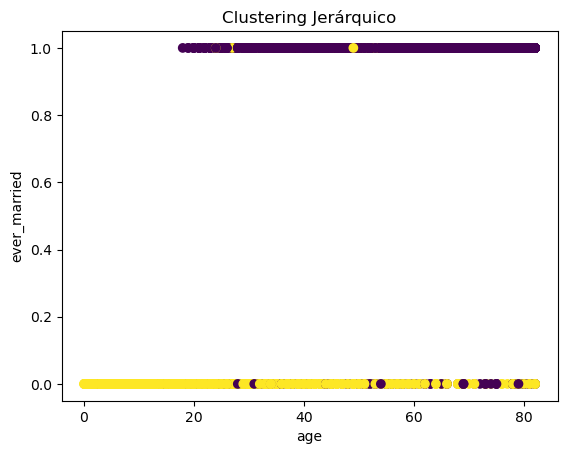

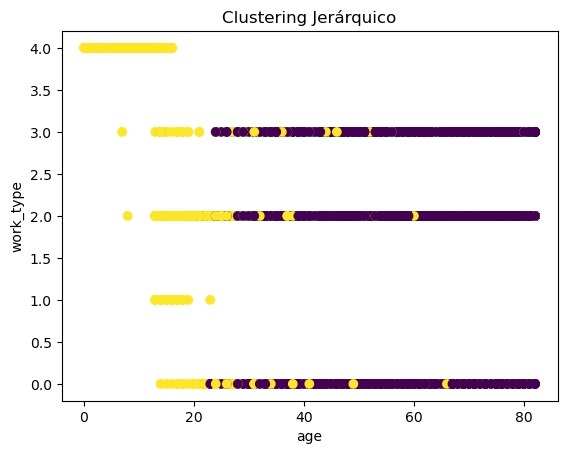

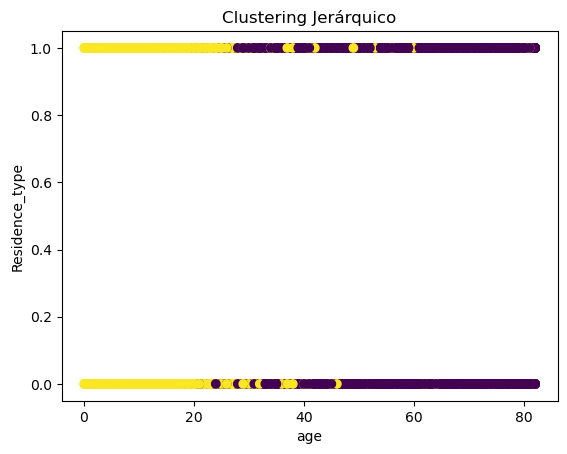

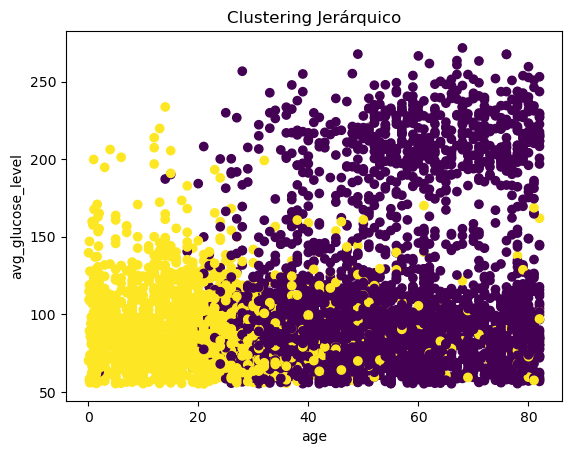

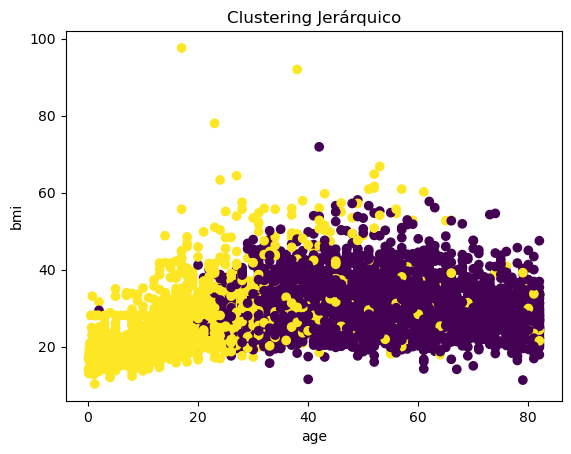

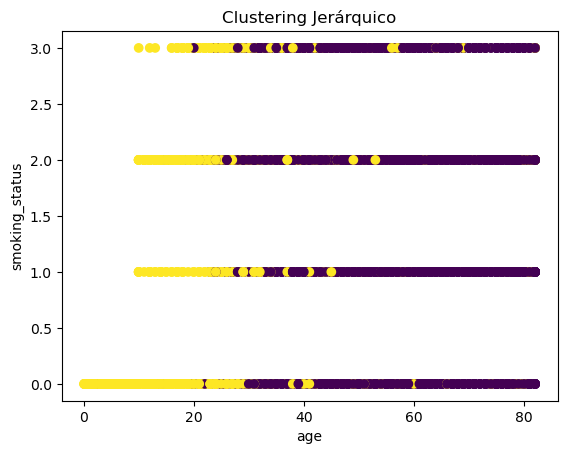

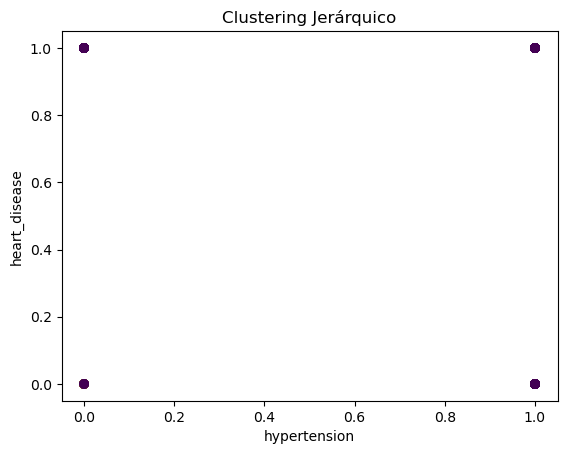

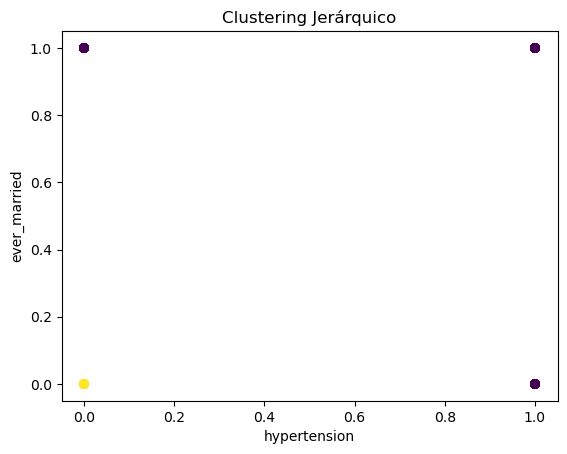

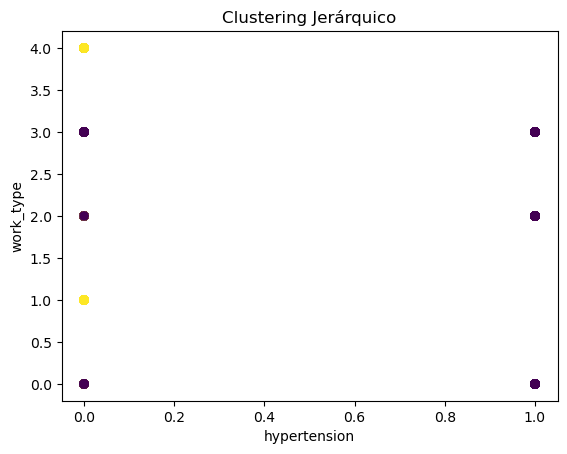

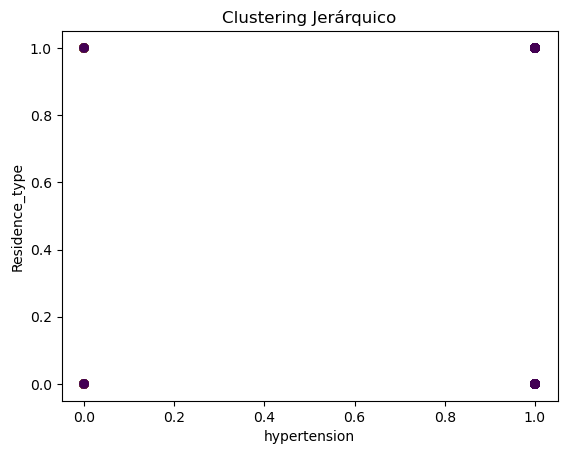

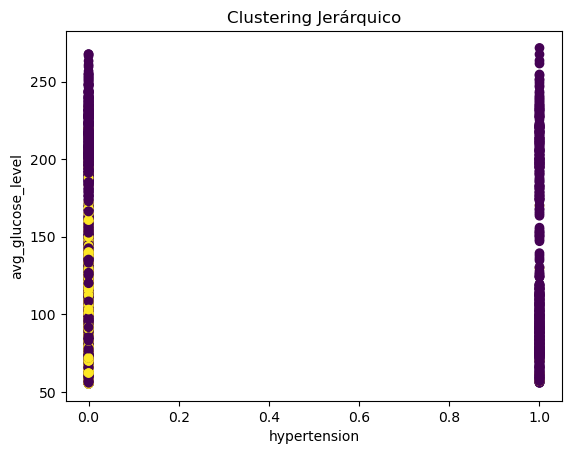

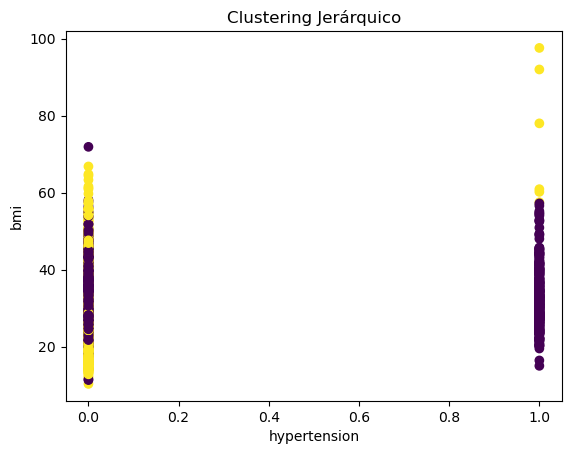

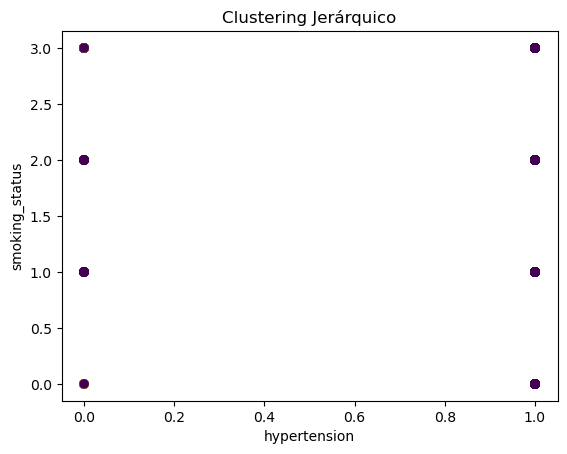

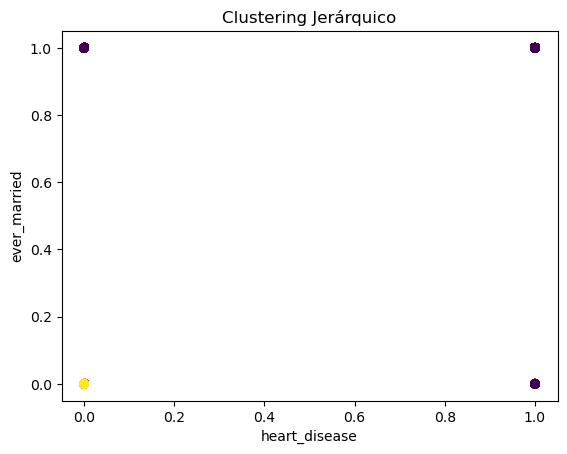

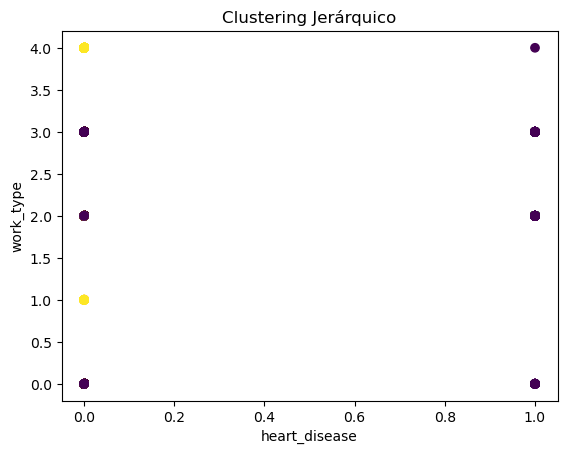

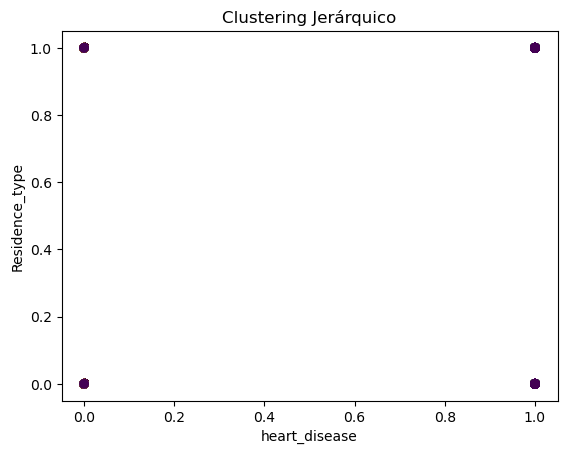

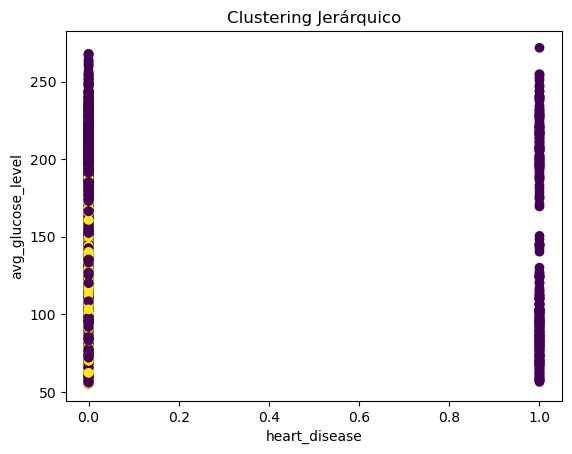

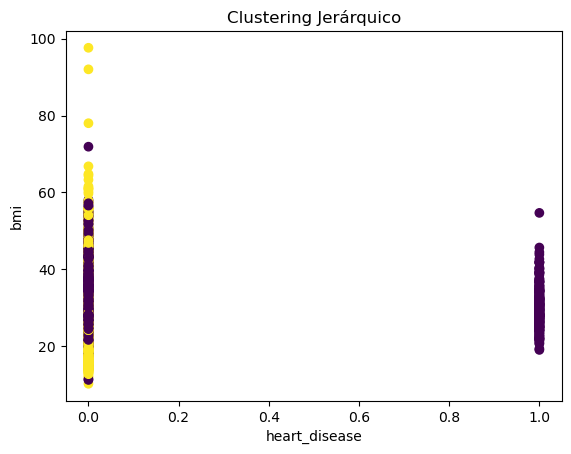

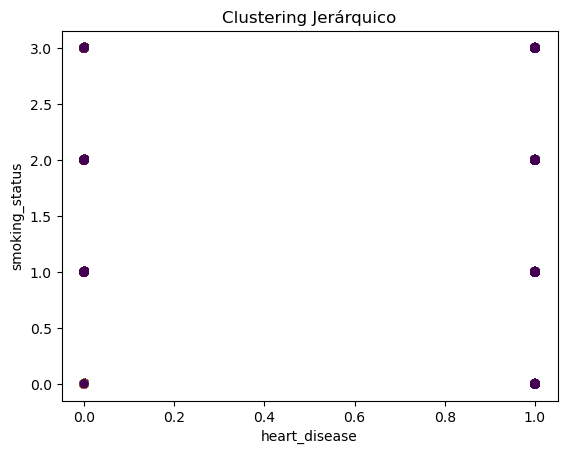

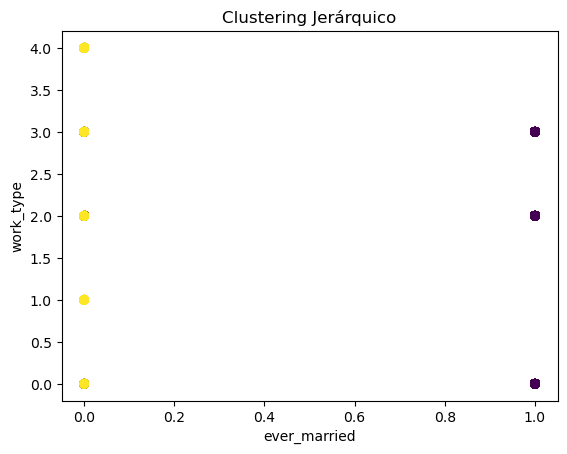

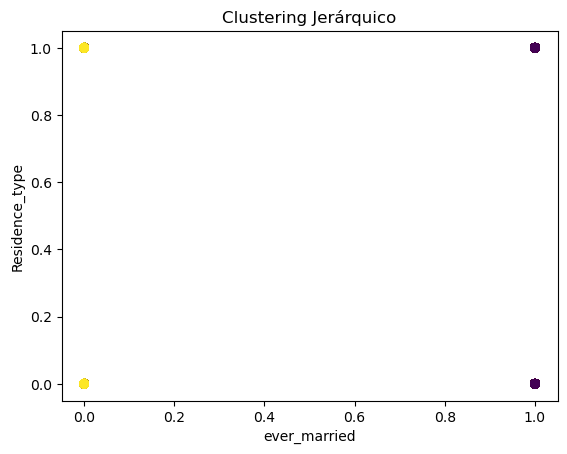

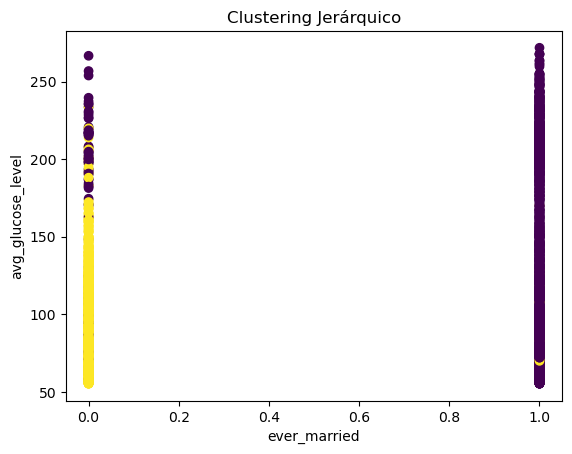

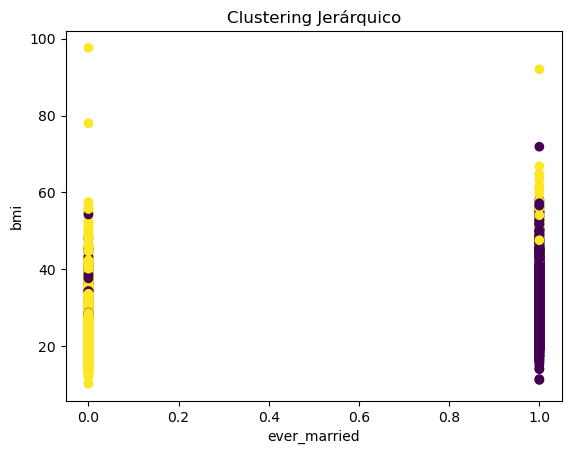

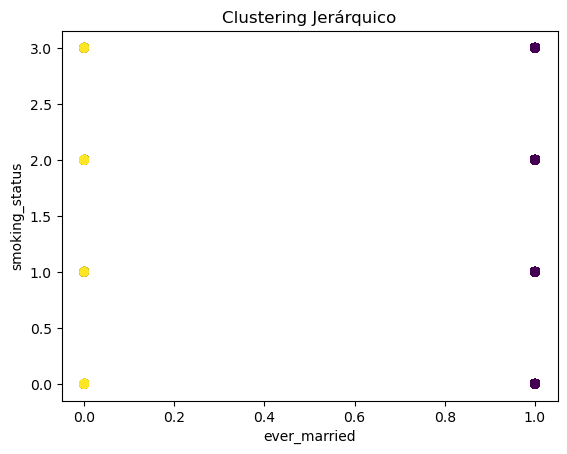

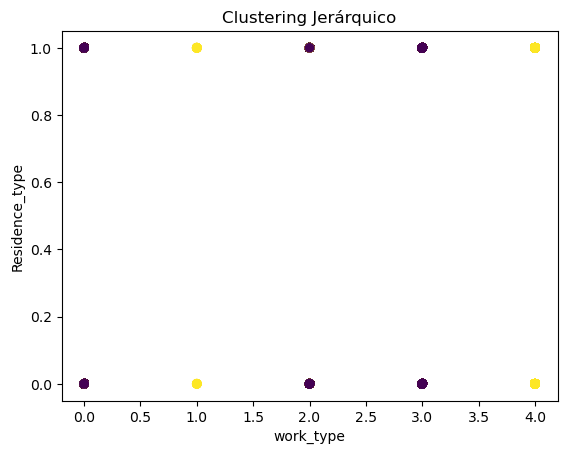

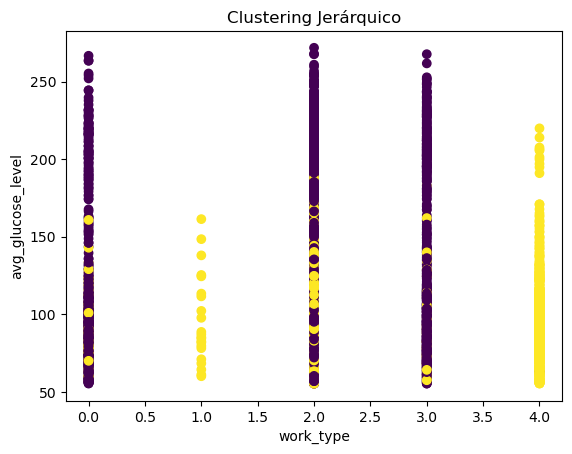

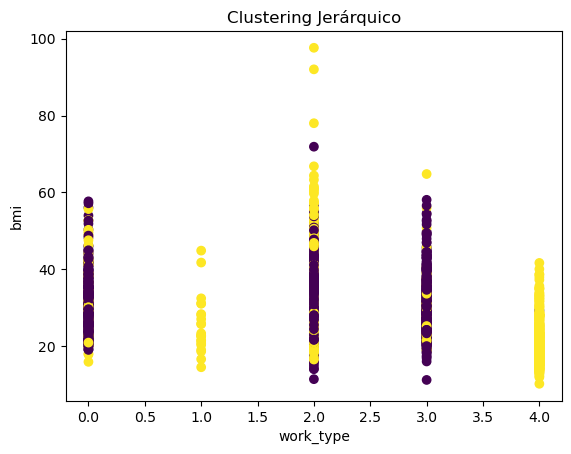

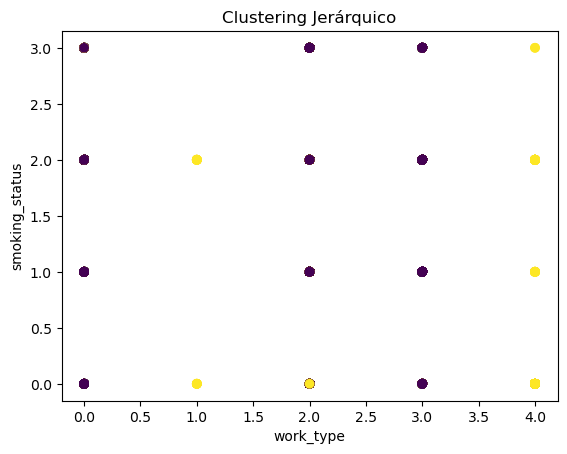

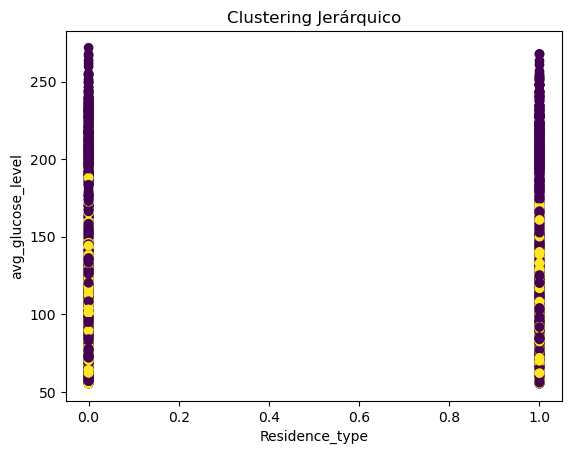

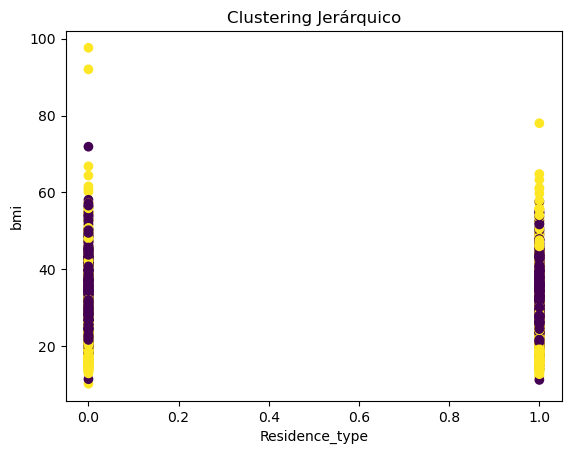

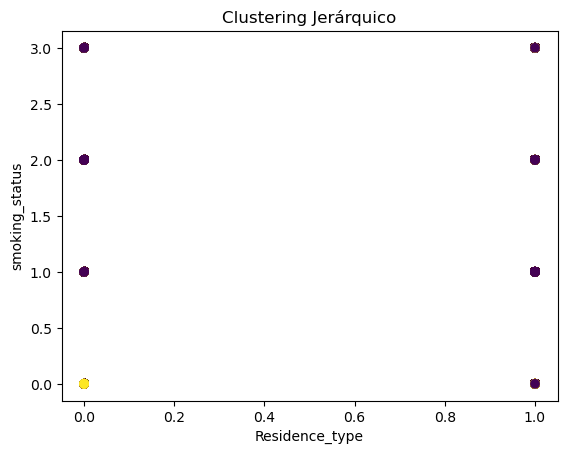

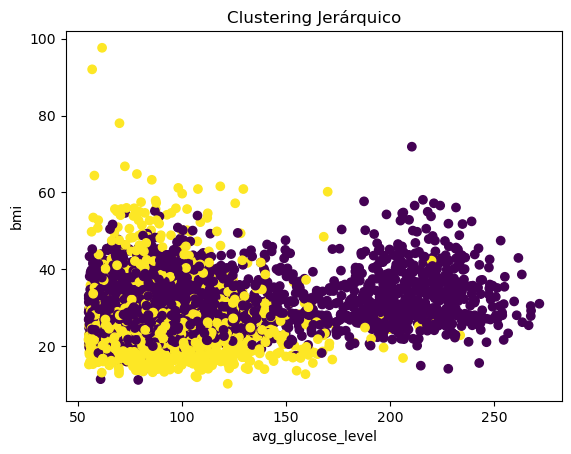

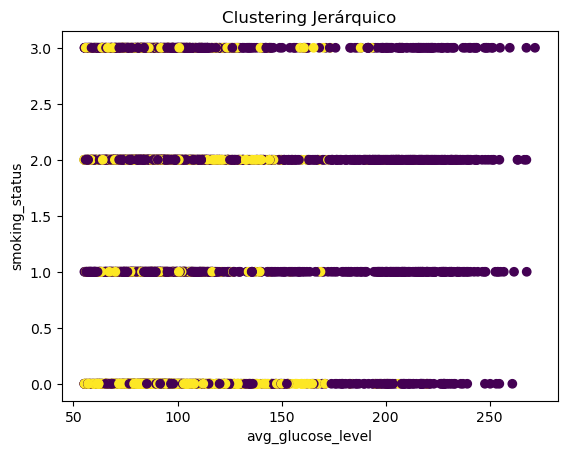

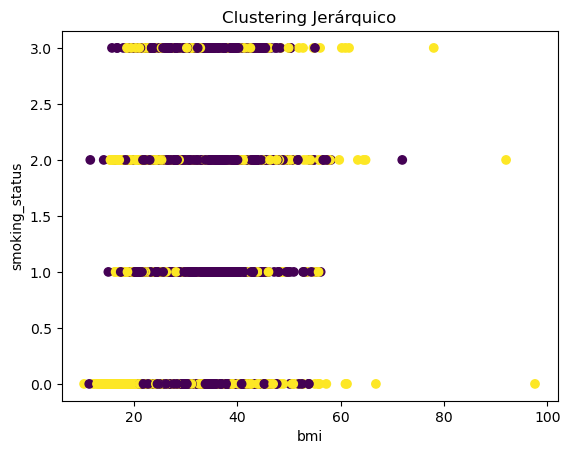

In [658]:
# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar clustering jerárquico
clustering = AgglomerativeClustering()
clustering.fit(X_scaled)

# Obtener las etiquetas de los clusters
labels = clustering.labels_

# Agregar las etiquetas de los clusters al DataFrame original
datos['Cluster'] = labels

# Visualizar los resultados
# Puedes elegir las columnas que deseas utilizar en el gráfico


combinaciones = []

for i in X:
    for y in X:
        if ((i!=y) and (i+y not in combinaciones) and (y+i not in combinaciones)):
            combinaciones.append(i+y)
            plt.scatter(X[i], X[y], c=labels, cmap='viridis', label=labels)
            plt.xlabel(i)
            plt.ylabel(y)
            plt.title('Clustering Jerárquico')
            plt.show()




In [659]:
datos.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_category,age_group,glucose_category,Cluster
0,Male,67.0,False,True,True,Private,Urban,228.69,36.6,formerly smoked,True,Obesity,Elderly,High,0
1,Female,61.0,False,False,True,Self-employed,Rural,202.21,28.1,never smoked,True,Overweight,Elderly,High,0
2,Male,80.0,False,True,True,Private,Rural,105.92,32.5,never smoked,True,Obesity,Elderly,Normal,0
3,Female,49.0,False,False,True,Private,Urban,171.23,34.4,smokes,True,Obesity,Mid Adults,High,0
4,Female,79.0,True,False,True,Self-employed,Rural,174.12,24.0,never smoked,True,Ideal,Elderly,High,0


In [660]:
pd.DataFrame(datos["Cluster"].value_counts()).rename({"Cluster":"registros"}, axis=1)


,registros
0,3409
1,1700


In [661]:
res = pd.DataFrame(datos.groupby("Cluster")["stroke"].sum())
res

,stroke
Cluster,
0,233
1,16


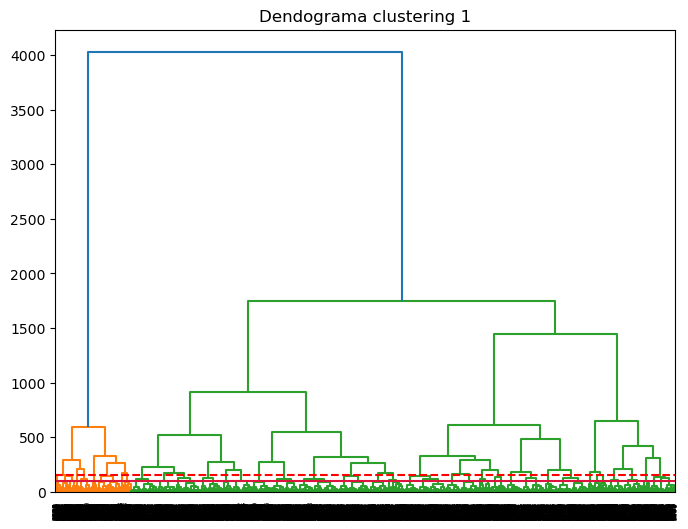

In [662]:
data = X

# Realizar cualquier otro preprocesamiento necesario

# Aplicar el clustering jerárquico utilizando el método de enlace 'ward'
clusters = hierarchy.linkage(data, method="ward")

# Visualizar el dendrograma
plt.figure(figsize=(8, 6))
dendrogram = hierarchy.dendrogram(clusters)

# Plotear una línea horizontal basada en la primera mayor distancia entre clusters
plt.axhline(150, color='red', linestyle='--')

# Plotear una línea horizontal basada en la segunda mayor distancia entre clusters
plt.axhline(100, color='crimson')

plt.title("Dendograma clustering 1")
# Mostrar el gráfico
plt.show()

In [663]:
# X es la matriz de características utilizada para el clustering
# labels son las etiquetas asignadas a cada objeto por el algoritmo de clustering
silhouette_avg = silhouette_score(X_scaled, labels)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.18470010427125289


### Clustering solo cualitativas

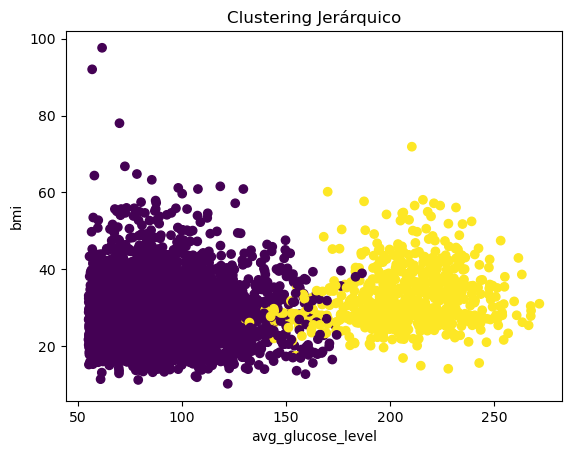

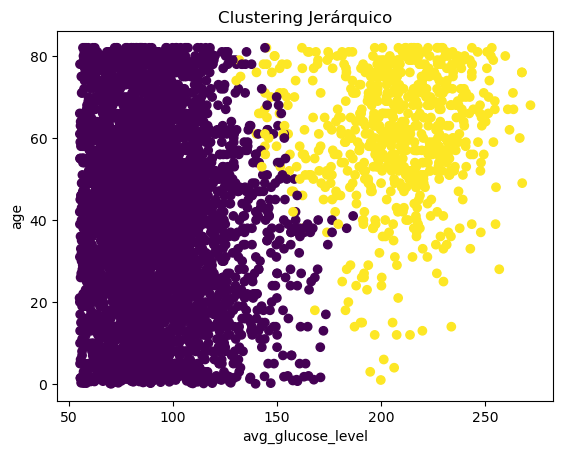

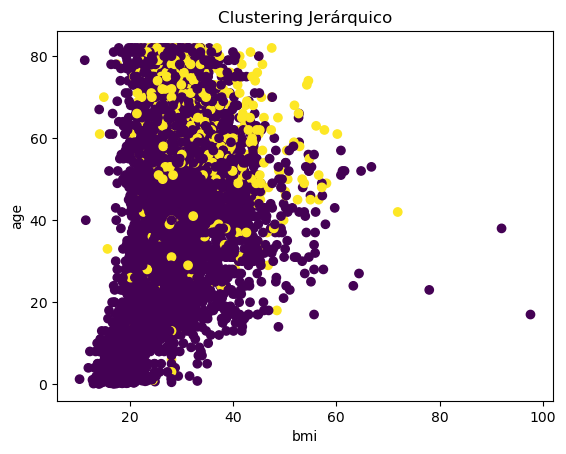

In [688]:
X = xcopia[["avg_glucose_level", "bmi", "age"]]
# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar clustering jerárquico
clustering = AgglomerativeClustering()
clustering.fit(X_scaled)

# Obtener las etiquetas de los clusters
labels = clustering.labels_

# Visualizar los resultados
# Puedes elegir las columnas que deseas utilizar en el gráfico


combinaciones = []

for i in X:
    for y in X:
        if ((i!=y) and (i+y not in combinaciones) and (y+i not in combinaciones)):
            combinaciones.append(i+y)
            plt.scatter(X[i], X[y], c=labels, cmap='viridis')
            plt.xlabel(i)
            plt.ylabel(y)
            plt.title('Clustering Jerárquico')
            plt.show()

X["Cluster"] = labels


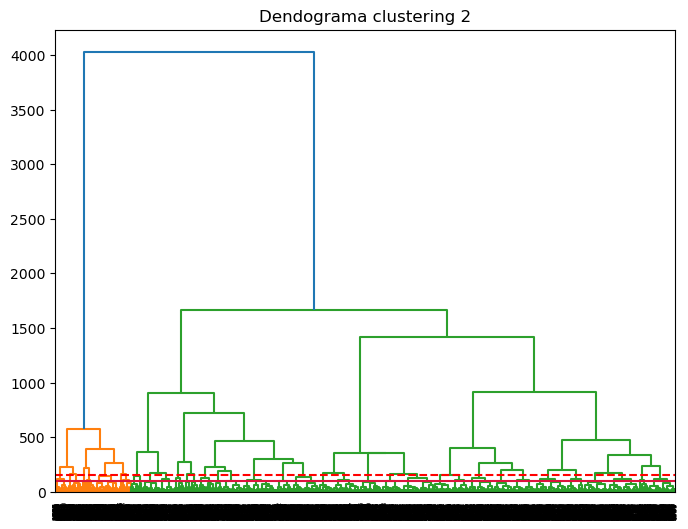

In [689]:
data = X

# Realizar cualquier otro preprocesamiento necesario

# Aplicar el clustering jerárquico utilizando el método de enlace 'ward'
clusters = hierarchy.linkage(data, method="ward")

# Visualizar el dendrograma
plt.figure(figsize=(8, 6))
dendrogram = hierarchy.dendrogram(clusters)

# Plotear una línea horizontal basada en la primera mayor distancia entre clusters
plt.axhline(150, color='red', linestyle='--')

# Plotear una línea horizontal basada en la segunda mayor distancia entre clusters
plt.axhline(100, color='crimson')

plt.title("Dendograma clustering 2")

# Mostrar el gráfico
plt.show()

In [690]:
silhouette_avg = silhouette_score(X_scaled, labels)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.4297033121332333


In [667]:
pd.DataFrame(X.Cluster.value_counts()).rename({"Cluster":"registros"}, axis=1)

,registros
0,4428
1,681


In [668]:
X["stroke"] = datos["stroke"]

In [669]:
X.head()

,avg_glucose_level,bmi,age,Cluster,stroke
0,228.69,36.6,67.0,1,True
1,202.21,28.1,61.0,1,True
2,105.92,32.5,80.0,0,True
3,171.23,34.4,49.0,1,True
4,174.12,24.0,79.0,1,True


In [670]:
res = pd.DataFrame(X.groupby("Cluster")["stroke"].sum())
res["probabilidad de sufrir un paro"] = res.stroke/X.Cluster.value_counts()
res

,stroke,probabilidad de sufrir un paro
Cluster,,
0,157,0.035456
1,92,0.135095


### Clustering selectivo

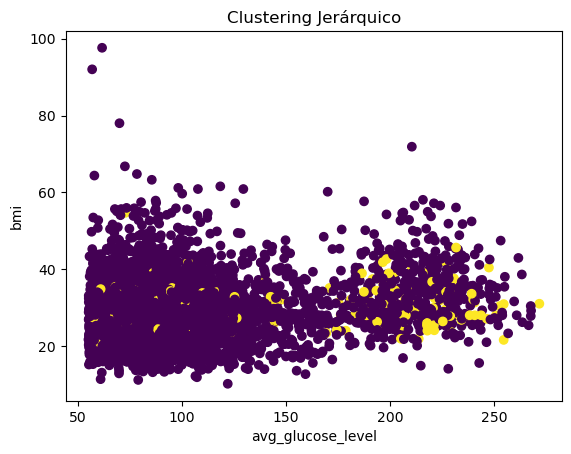

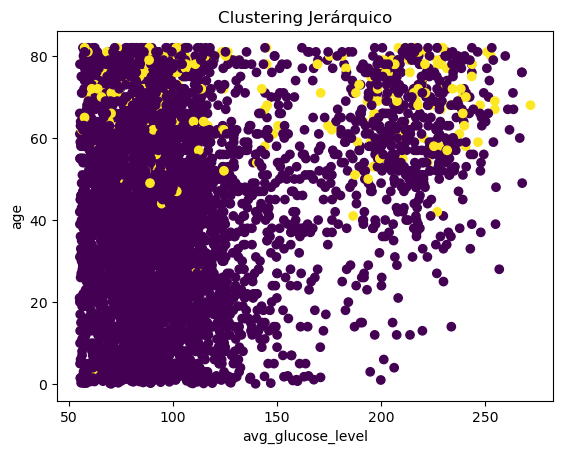

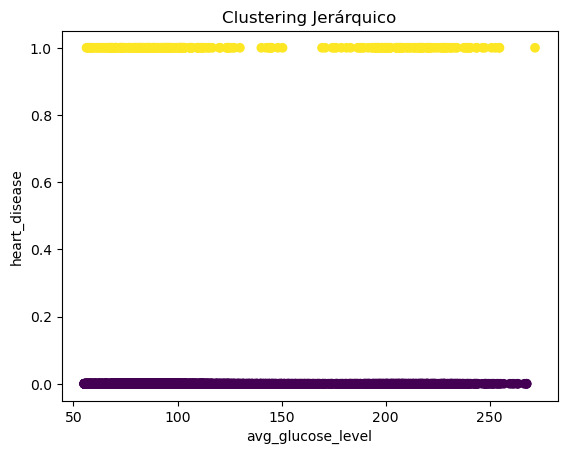

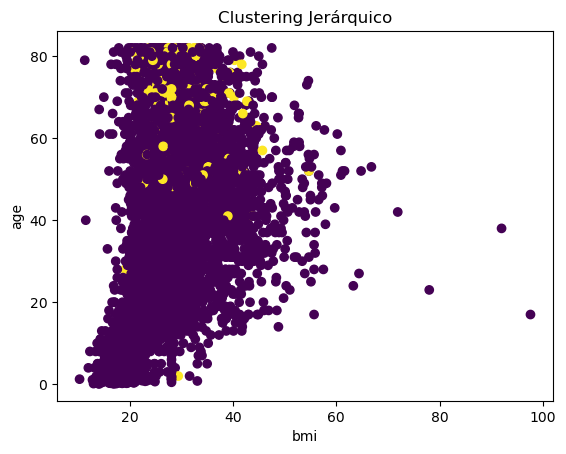

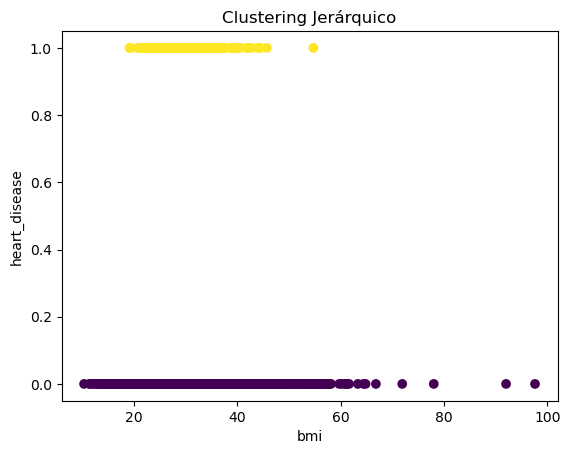

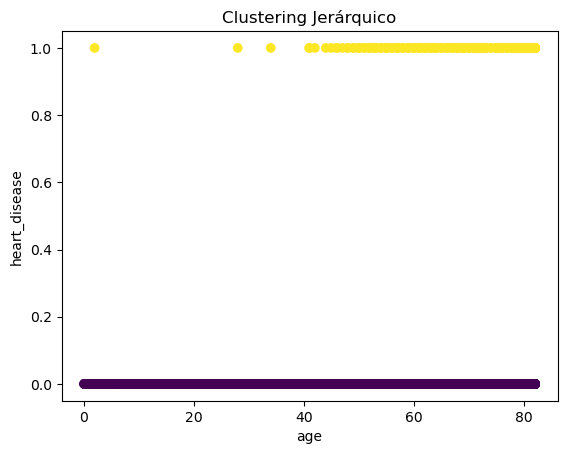

Silhouette Score: 0.585900023258647


In [671]:
X = xcopia[["avg_glucose_level", "bmi", "age", "heart_disease"]]
# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar clustering jerárquico
clustering = AgglomerativeClustering()
clustering.fit(X_scaled)

# Obtener las etiquetas de los clusters
labels = clustering.labels_

combinaciones = []

for i in X:
    for y in X:
        if ((i!=y) and (i+y not in combinaciones) and (y+i not in combinaciones)):
            combinaciones.append(i+y)
            plt.scatter(X[i], X[y], c=labels, cmap='viridis')
            plt.xlabel(i)
            plt.ylabel(y)
            plt.title('Clustering Jerárquico')
            plt.show()

X["Cluster"] = labels
silhouette_avg = silhouette_score(X_scaled, labels)
print("Silhouette Score:", silhouette_avg)


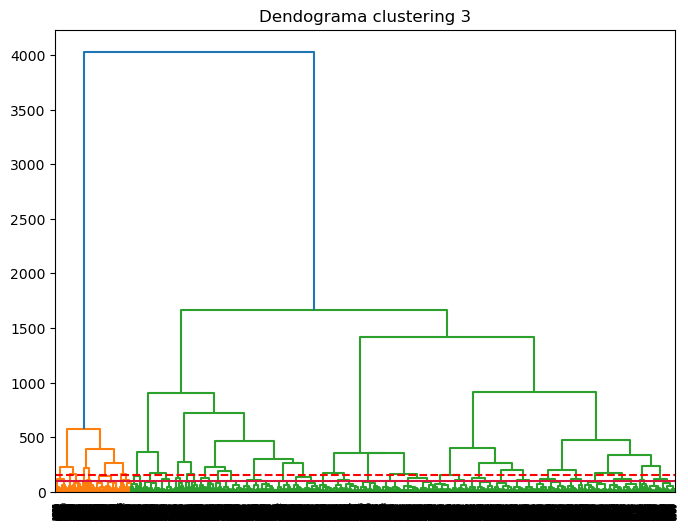

In [691]:
data = X

# Realizar cualquier otro preprocesamiento necesario

# Aplicar el clustering jerárquico utilizando el método de enlace 'ward'
clusters = hierarchy.linkage(data, method="ward")

# Visualizar el dendrograma
plt.figure(figsize=(8, 6))
dendrogram = hierarchy.dendrogram(clusters)

# Plotear una línea horizontal basada en la primera mayor distancia entre clusters
plt.axhline(150, color='red', linestyle='--')

# Plotear una línea horizontal basada en la segunda mayor distancia entre clusters
plt.axhline(100, color='crimson')

plt.title("Dendograma clustering 3")

# Mostrar el gráfico
plt.show()

In [673]:
display(pd.DataFrame(X.Cluster.value_counts()).rename({"Cluster":"registros"}, axis=1))
X["stroke"] = datos["stroke"]


,registros
0,4833
1,276


In [674]:
res = pd.DataFrame(X.groupby("Cluster")["stroke"].sum())
res["probabilidad de sufrir un paro"] = res.stroke/X.Cluster.value_counts()
res

,stroke,probabilidad de sufrir un paro
Cluster,,
0,202,0.041796
1,47,0.170290


### Mezcla gaussiana

In [675]:
X = datos.drop(columns=["stroke", "bmi_category", "age_group", "glucose_category", "Cluster"])
y = datos["stroke"]

label_encoder = LabelEncoder()
labels = {}

for i in X:
    if isinstance(X[i][0],str):
        X[i] = label_encoder.fit_transform(datos[i])
        labels[i]=label_encoder.classes_

X.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,1,67.0,False,True,True,2,1,228.69,36.6,1
1,0,61.0,False,False,True,3,0,202.21,28.1,2
2,1,80.0,False,True,True,2,0,105.92,32.5,2
3,0,49.0,False,False,True,2,1,171.23,34.4,3
4,0,79.0,True,False,True,3,0,174.12,24.0,2


In [676]:
modelo_gmm = GMM(
                n_components    = 4,
                covariance_type = 'full',
                random_state    = 123
             )

modelo_gmm.fit(X=X)

GaussianMixture(n_components=4, random_state=123)

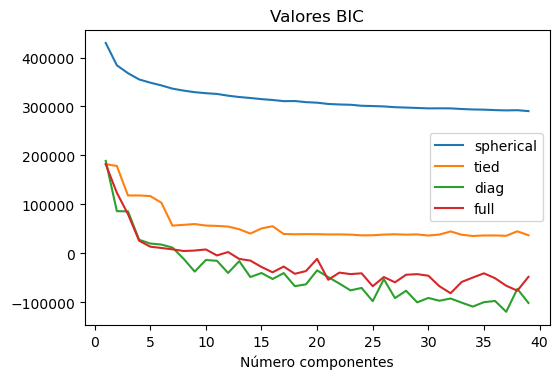

In [677]:
# Tuning
fig, ax = plt.subplots(figsize=(6, 3.84))

n_components = range(1, 40)
covariance_types = ['spherical', 'tied', 'diag', 'full']

for covariance_type in covariance_types:
    valores_bic = []
    
    for i in n_components:
        modelo = GMM(n_components=i, covariance_type=covariance_type)
        modelo = modelo.fit(X)
        valores_bic.append(modelo.bic(X))

        
    ax.plot(n_components, valores_bic, label=covariance_type)
        
ax.set_title("Valores BIC")
ax.set_xlabel("Número componentes")
ax.legend();

In [678]:
modelo_gmm = GMM(
                n_components    = 34,
                covariance_type = 'diag',
                random_state    = 123, 
             )

modelo_gmm.fit(X=X)

GaussianMixture(covariance_type='diag', n_components=34, random_state=123)

In [679]:
log_probabilidad_predicha = modelo_gmm.score_samples(X=X)
log_probabilidad_predicha

array([ 0.27417174, 11.47535839,  0.38152384, ..., 13.55257324,
       13.95961893, 19.42391437])

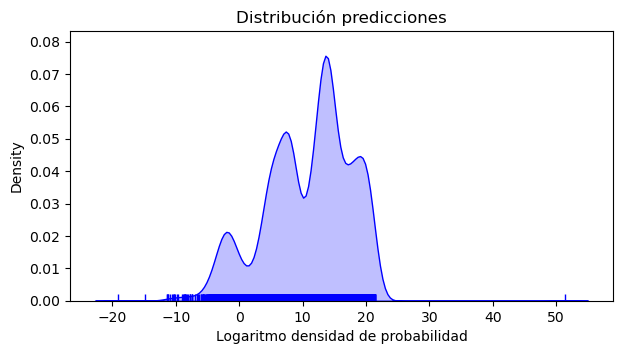

In [680]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
sns.distplot(
    log_probabilidad_predicha,
    hist    = False,
    rug     = True,
    color   = 'blue',
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = ax
)

ax.set_title('Distribución predicciones')
ax.set_xlabel('Logaritmo densidad de probabilidad');

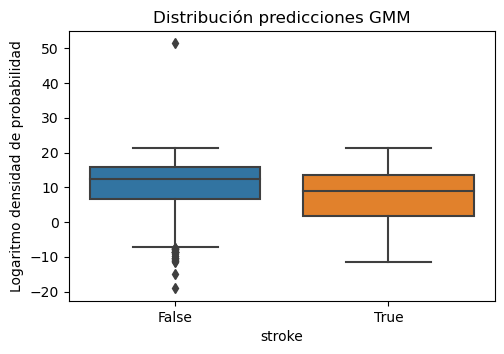

In [681]:
df_resultados = pd.DataFrame({
                    'log_probabilidad' : log_probabilidad_predicha,
                    'anomalia' : y
                })

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5, 3.5))
sns.boxplot(
    x     = 'anomalia',
    y     = 'log_probabilidad',
    data  = df_resultados,
    #color = "white",
    palette = 'tab10',
    ax    = ax
)

ax.set_title('Distribución predicciones GMM')
ax.set_ylabel('Logaritmo densidad de probabilidad')
ax.set_xlabel('stroke');

In [682]:
df_resultados = df_resultados \
                .sort_values('log_probabilidad', ascending=True) \
                .reset_index(drop=True)

df_resultados['clasificacion'] = np.where(df_resultados.index <= 176, 1, 0)

matriz = pd.crosstab(
        df_resultados.anomalia,
        df_resultados.clasificacion,
        rownames=["stroke"],
        margins=True
        )

display(matriz)

print("Probabilidad de falso positivo:",round(matriz[0][0]/matriz[0][2],2))
print("Probabilidad de falso negativo:",round(matriz[0][1]/matriz[0][2], 2))
print("Probabilidad de verdadero negativo:",round(matriz[1][0]/matriz[1][2],2))
print("Probabilidad de verdadero positivo:",round(matriz[1][1]/matriz[1][2],2))


clasificacion,0,1,All
stroke,,,
False,4702,158,4860
True,230,19,249
All,4932,177,5109


Probabilidad de falso positivo: 0.95
Probabilidad de falso negativo: 0.05
Probabilidad de verdadero negativo: 0.89
Probabilidad de verdadero positivo: 0.11


In [683]:
etiquetas = modelo_gmm.predict(X)
puntuacion_silueta = silhouette_score(X, etiquetas)

print("La puntuación de silueta es:", puntuacion_silueta)


La puntuación de silueta es: -0.3872487664052775


In [684]:
cuantil = np.quantile(a=log_probabilidad_predicha,  q=0.0001)
print('Cuantil: ', cuantil)
datos_X_trimmed = X.loc[log_probabilidad_predicha > cuantil, :].copy()
datos_y_trimmed = y[log_probabilidad_predicha > cuantil].copy()

Cuantil:  -16.932870997933662


In [685]:
modelo_gmm = GMM(
                n_components    = 34,
                covariance_type = 'diag',
                random_state    = 123, 
             )

modelo_gmm.fit(X=datos_X_trimmed)

GaussianMixture(covariance_type='diag', n_components=34, random_state=123)

In [686]:
df_resultados = pd.DataFrame({
                    'log_probabilidad': modelo_gmm.score_samples(X=X),
                    'anomalia' : y
                })

df_resultados = df_resultados \
                .sort_values('log_probabilidad', ascending=True) \
                .reset_index(drop=True)

df_resultados['clasificacion'] = np.where(df_resultados.index <= 176, 1, 0)

matriz1 = pd.crosstab(
        df_resultados.anomalia,
        df_resultados.clasificacion,
        rownames=["stroke"],
        )

display(matriz1)


clasificacion,0,1
stroke,,
False,4712,148
True,220,29


In [687]:
etiquetas = modelo_gmm.predict(X)
puntuacion_silueta = silhouette_score(X, etiquetas)

print("La puntuación de silueta es:", puntuacion_silueta)

La puntuación de silueta es: -0.3464113000603149


### DBSCAN

In [693]:
df=datos
print(df.dtypes)

gender               category
age                   float64
hypertension             bool
heart_disease            bool
ever_married             bool
work_type            category
Residence_type       category
avg_glucose_level     float64
bmi                   float64
smoking_status       category
stroke                   bool
bmi_category         category
age_group            category
glucose_category     category
Cluster                 int64
dtype: object


In [695]:
#aplicar encoding para los tipos de datos

label_encoder = LabelEncoder()
df['gender'] = label_encoder.fit_transform(df['gender'])
df['work_type'] = label_encoder.fit_transform(df['work_type'])
df['Residence_type'] = label_encoder.fit_transform(df['Residence_type'])
df['smoking_status'] = label_encoder.fit_transform(df['smoking_status'])
df['bmi_category'] = label_encoder.fit_transform(df['bmi_category'])
df['age_group'] = label_encoder.fit_transform(df['age_group'])
df['glucose_category'] = label_encoder.fit_transform(df['glucose_category'])
df['hypertension'] = df['hypertension'].astype(int)
df['heart_disease'] = df['heart_disease'].astype(int)
df['ever_married'] = df['ever_married'].astype(int)
df['stroke'] = df['stroke'].astype(int)
print(df.dtypes)


gender                 int64
age                  float64
hypertension           int64
heart_disease          int64
ever_married           int64
work_type              int64
Residence_type         int64
avg_glucose_level    float64
bmi                  float64
smoking_status         int64
stroke                 int64
bmi_category           int64
age_group              int64
glucose_category       int64
Cluster                int64
dtype: object


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Number of clusters: 33


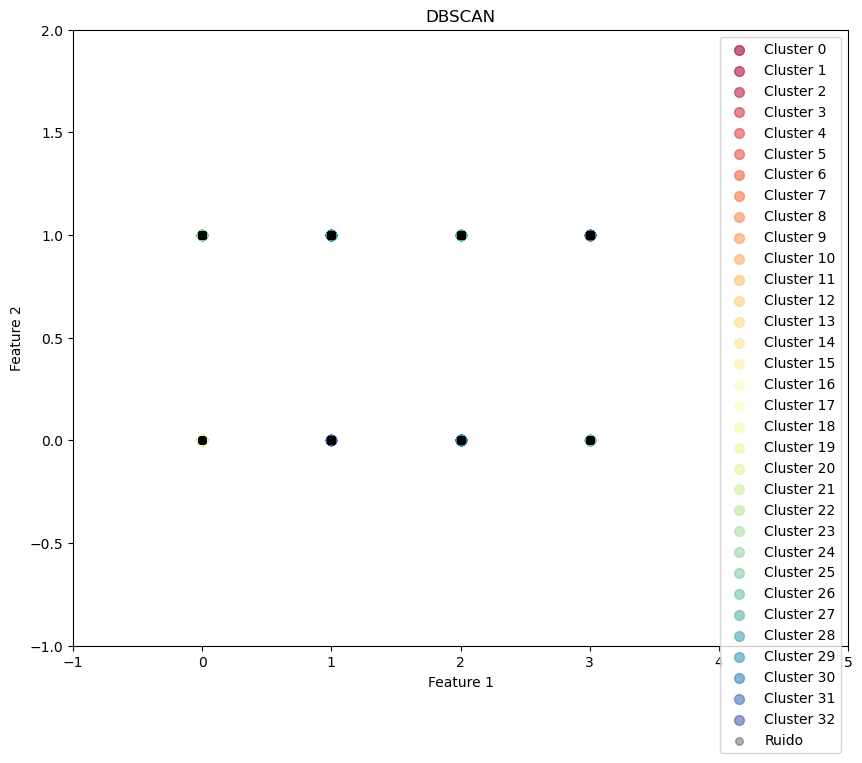

In [698]:
df = datos 

# features para hacer los clusters
features = df[['smoking_status', 'ever_married', 'stroke', 'gender', 'glucose_category', 'heart_disease']].values

# formar clusters
dbscan = DBSCAN(eps=0.9, min_samples=30)
labels = dbscan.fit_predict(features)

# Extraer el numero de clusters 1 y de ruido -1
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Number of clusters: {num_clusters}")

# Plot los clusters
u_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(u_labels)))

plt.figure(figsize=(10, 8))

for label, color in zip(u_labels, colors):
    if label == -1:
        # Ruido
        cluster_p = features[labels == label]
        plt.scatter(cluster_p[:, 0], cluster_p[:, 1], c='black', alpha=0.3, s=30, label='Ruido')
    else:
        # Normal 
        cluster_p = features[labels == label]
        plt.scatter(cluster_p[:, 0], cluster_p[:, 1], c=color, alpha=0.6, s=50, label=f'Cluster {label}')

plt.title('DBSCAN')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.xlim([-1, 5])  
plt.ylim([-1, 2])  
plt.show()

In [699]:
silhouette_avg = silhouette_score(df[['smoking_status', 'ever_married', 'bmi', 'gender']], labels)
print(f"Silhouette coefficient: {silhouette_avg}")

Silhouette coefficient: -0.2165353963794788
